In [8]:
#lets import the required libraries.
import numpy as np # mathematical computation
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization
from matplotlib import pyplot
import seaborn as sns # visualization
import warnings 
warnings.filterwarnings('ignore') #ignore warnings

#machine Learning models Libraries
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

#Preprocessing related Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#Date related Libraries
from datetime import date
import holidays
import datetime

In [9]:
#Deeplearning related Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [10]:
import os
suffix = '.csv'
for dirname, _, filenames in os.walk('data/walmart-recruiting-store-sales-forecasting'):
    for filename in filenames:
        if filename.endswith(suffix):
            print(os.path.join(dirname, filename))

data/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv
data/walmart-recruiting-store-sales-forecasting/test.csv
data/walmart-recruiting-store-sales-forecasting/train.csv
data/walmart-recruiting-store-sales-forecasting/features.csv
data/walmart-recruiting-store-sales-forecasting/stores.csv


In [11]:
#Reading the dataset in Pandas
train=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/train.csv")
test=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/test.csv")
stores=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/stores.csv")
features = pd.read_csv("data/walmart-recruiting-store-sales-forecasting/features.csv")

In [7]:
print("the structure of train data is ", train.shape)
print("the structure of test  data is ", test.shape)

the structure of train data is  (421570, 5)
the structure of test  data is  (115064, 4)


In [8]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [226]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [12]:
#convert date column into datetime type

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
features.Date = pd.to_datetime(features.Date)

##  exract the time based feature from Date feature

In [ ]:
dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holidays_list=[] 
for index, row in train.iterrows():
    dat = train['Date'][index]
    dt=[]
    for i in range(0,5):
        dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
        dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
        if date in dt:
            count +=1
    holidays_list.append(count)
    
train['Holidays'] = np.array(holidays_list)

In [13]:
train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Week']=train['Date'].dt.week
train['Day']=train['Date'].dt.day
train['n_days']=(train['Date'].dt.date-train['Date'].dt.date.min()).apply(lambda x:x.days)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days
0,1,1,2010-02-05,24924.50,False,2010,2,5,5,0
1,1,1,2010-02-12,46039.49,True,2010,2,6,12,7
2,1,1,2010-02-19,41595.55,False,2010,2,7,19,14
3,1,1,2010-02-26,19403.54,False,2010,2,8,26,21
4,1,1,2010-03-05,21827.90,False,2010,3,9,5,28


## the impact of holidays on Sales

In [229]:
print("Holiday")
print(train[train['IsHoliday']==True]['Weekly_Sales'].describe())
print("Non-Holiday")
print(train[train['IsHoliday']==False]['Weekly_Sales'].describe())

Holiday
count     29661.000000
mean      17035.823187
std       27222.000409
min        -798.000000
25%        2078.540000
50%        7947.740000
75%       21189.250000
max      693099.360000
Name: Weekly_Sales, dtype: float64
Non-Holiday
count    391909.000000
mean      15901.445069
std       22330.747450
min       -4988.940000
25%        2079.750000
50%        7589.950000
75%       20131.210000
max      406988.630000
Name: Weekly_Sales, dtype: float64


- sales in holiday week are more than sales in non-holiday week

## check if there is any trend , fluctuation or random event happen during the period of time provided.

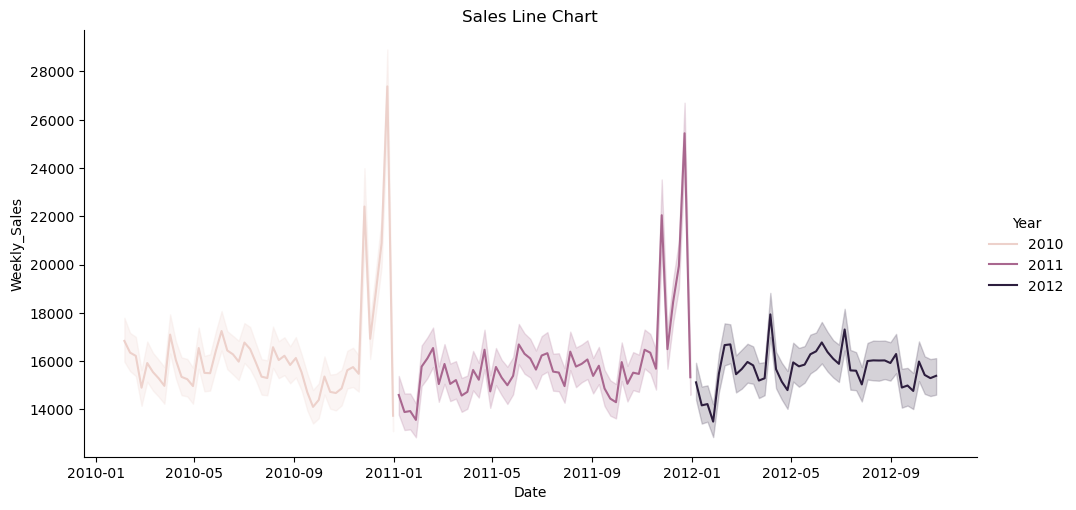

In [230]:
sns.relplot(x='Date',y='Weekly_Sales',hue='Year',data=train, kind='line',aspect=2)
plt.title("Sales Line Chart")
plt.show()

- It can be seen through Line chart that there is no trend in year wise and no random event also happen in any year
- Also it can be seen that at the end of the year there is hufe sales compared to other month whih tells that christmas and thanksgiving has more impact on sales compared to Super Bowl ,Labour Day.


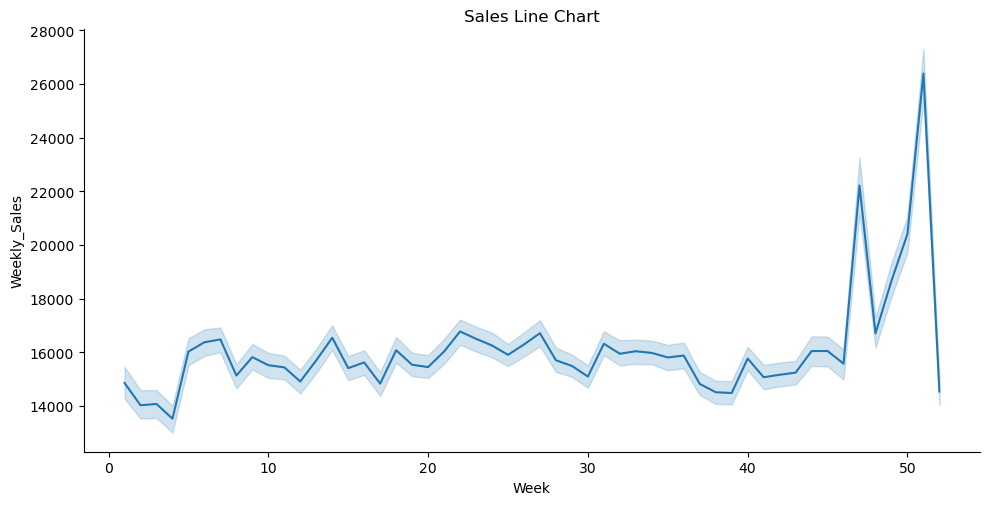

In [231]:
sns.relplot(x='Week',y='Weekly_Sales',data=train, kind='line',aspect=2)
plt.title("Sales Line Chart")
plt.show()

- Here Also it can be seen that week 45 to 50 have higher sales where christmas and thanksgiving comes

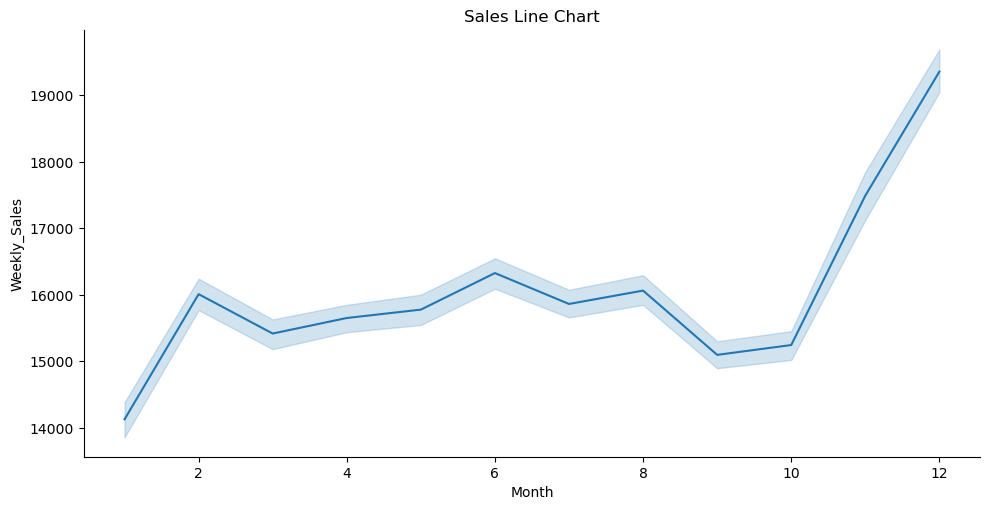

In [232]:
sns.relplot(x='Month',y='Weekly_Sales',data=train, kind='line',aspect=2)
plt.title("Sales Line Chart")
plt.show()

- It can be seen that in november and december sales are very high compared to other month wich tells the impact of thanksgiving and christmas on sales.

## merge train.csv with stores.csv and features.csv to get more features for each data point in train.csv


In [233]:
stores = stores.merge(features, on ='Store' , how = 'left')
train = train.merge(stores, on = ['Store', 'Date', 'IsHoliday'], how = 'left')
train.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days,...,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,2010,2,5,5,0,...,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,2010,2,6,12,7,...,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,2010,2,7,19,14,...,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,2010,2,8,26,21,...,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,2010,3,9,5,28,...,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


## check which features are more correlated to weekly_sales 
- Correlation between Categorical deatures with weekly_sales 

In [234]:
#This function is creating eta square test
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [238]:
print("Correlation of Store feature with Weekly_Sales")
print(correlation_ratio(train['Store'],train['Weekly_Sales']))
print(50*'*')
print("Correlation of Department feature with Weekly_Sales")
print(correlation_ratio(train['Dept'],train['Weekly_Sales']))
print(50*'*')
print("Correlation of Type feature with Weekly_Sales")
print(correlation_ratio(train['Type'],train['Weekly_Sales']))
print(50*'*')

Correlation of Store feature with Weekly_Sales
0.09320619110455744
**************************************************
Correlation of Department feature with Weekly_Sales
0.5368007370698533
**************************************************
Correlation of Type feature with Weekly_Sales
0.035527338793980845
**************************************************


- As it can be see that correlation between Department and Weekly_sales is highest.
- Store and Type is Also Correlated

## Correlation of  Numerical feature with Weekly_sales

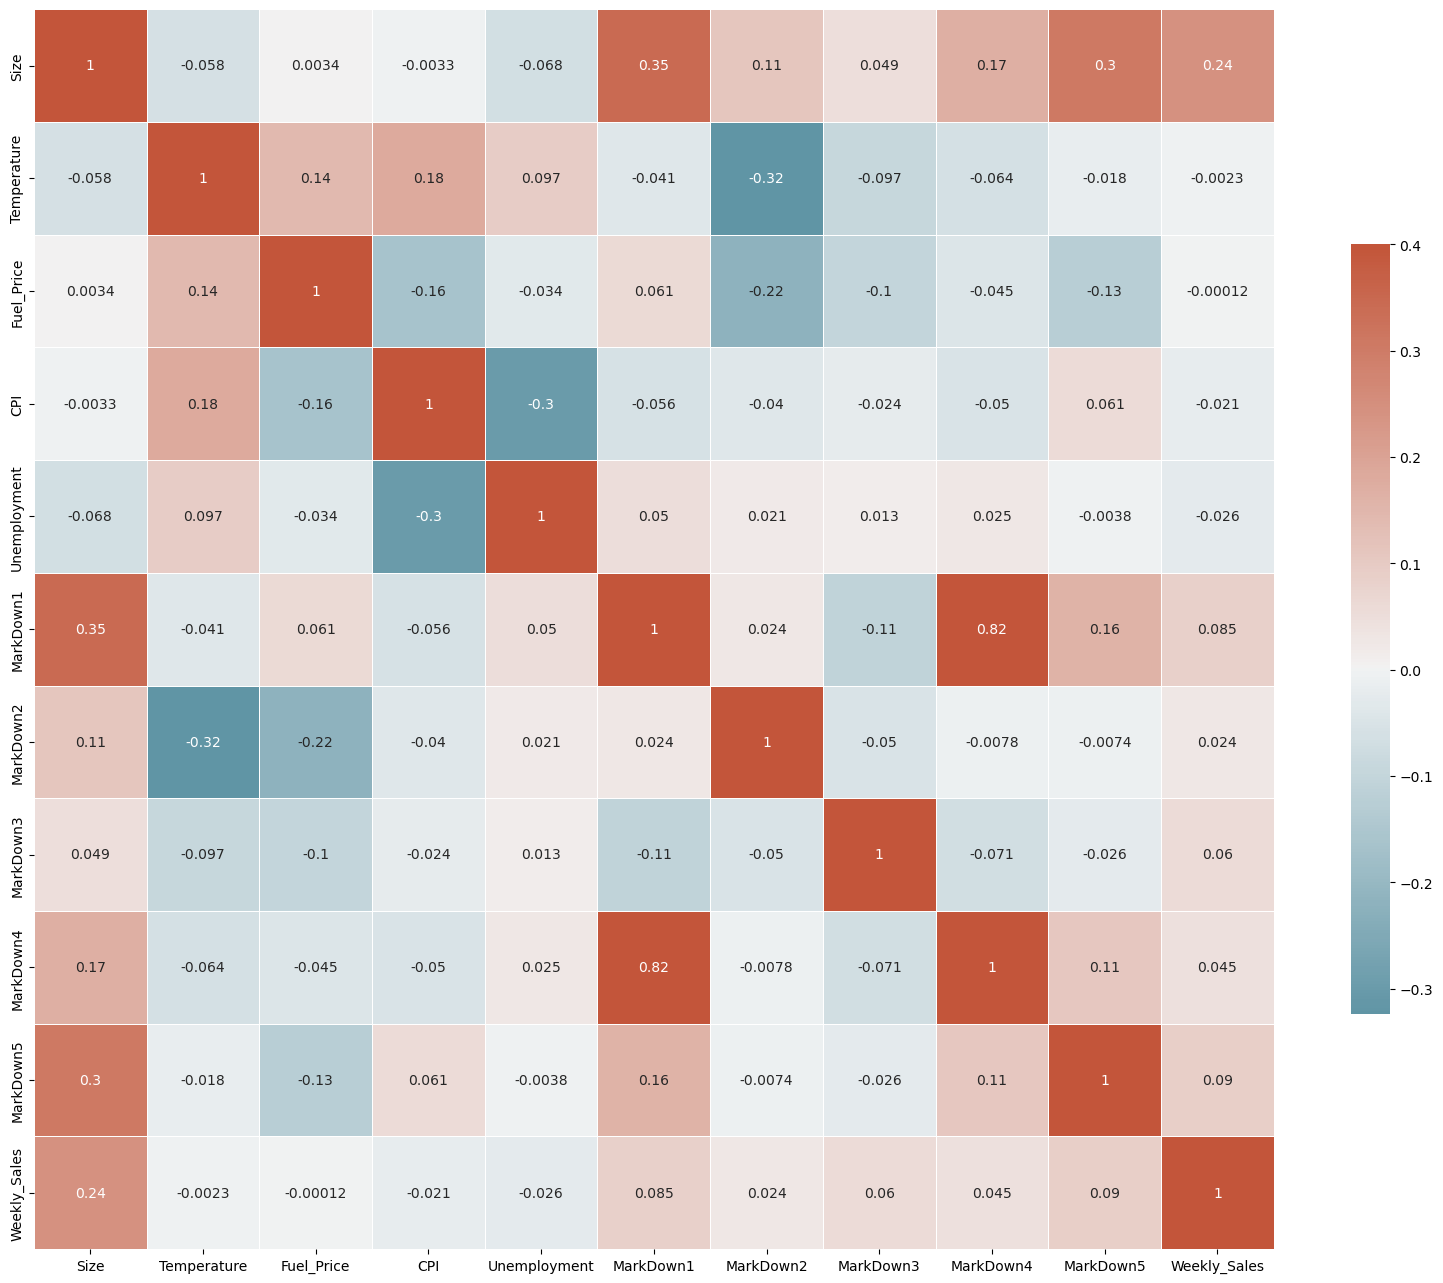

In [133]:
data = pd.concat([train['Size'], train['Temperature'],train['Fuel_Price'],train['CPI'],train['Unemployment'],
                  train['MarkDown1'],train['MarkDown2'],train['MarkDown3'],train['MarkDown4'],
                  train['MarkDown5'],train['Weekly_Sales']], axis=1)
corr = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.4, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

## check which features are important using Simple Random Forest model.

In [239]:
data = train.loc[:, train.columns != 'Weekly_Sales']
data = data.loc[:, data.columns != 'Date']
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
d=imp.fit_transform(pd.concat([data['MarkDown1'],data['MarkDown2'],
                               data['MarkDown3'],data['MarkDown4'],data['MarkDown5']],axis = 1))
data['MarkDown1'] = d[:,0]
data['MarkDown2'] = d[:,1]
data['MarkDown3'] = d[:,2]
data['MarkDown4'] = d[:,3]
data['MarkDown5'] = d[:,4]
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(data, train['Weekly_Sales'])

RandomForestRegressor()

In [135]:
feature_importance_values=clf.feature_importances_
features = np.array(data.columns)
important_features = [x for _,x in sorted(zip(feature_importance_values,features),reverse=True)]
print("Top 5 Important Features:")
print(important_features[0:5])

Top 5 Important Features:
['Dept', 'Size', 'Store', 'Week', 'CPI']


## look at the type of values in Stores dataset.

the shape of stores data set is:  (8190, 14)
the unique value of store is:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
the unique value of Type is:  ['A' 'B' 'C']


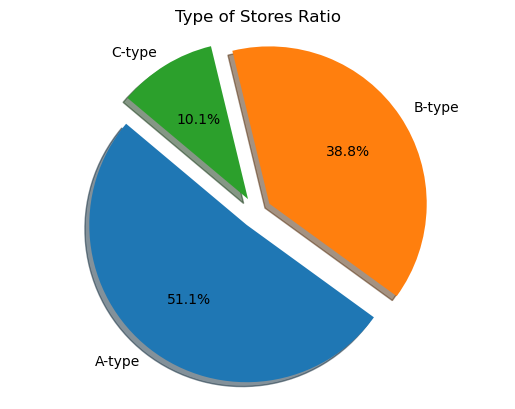

In [136]:
print("the shape of stores data set is: ", stores.shape)
print("the unique value of store is: ", stores['Store'].unique())
print("the unique value of Type is: ", stores['Type'].unique())


Count_A,Count_B,Count_C = train['Type'].value_counts()
Tasks = [Count_A,Count_B,Count_C]
explode = (0.1, 0.1, 0.1)  # explode 1st slice

i_labels = 'A-type','B-type','C-type'
plt.pie(Tasks,labels=i_labels,autopct='%1.1f%%',explode=explode,shadow=True, startangle=140)
plt.title('Type of Stores Ratio')
plt.axis('equal')
plt.show()

- As it can be seen that there are many stores of A-type and very less stores of C-type

#### look in terms of ratio of total size of each stores

In [137]:
grouped=stores.groupby('Type')
print(grouped.describe()['Size'])

       count           mean           std      min       25%       50%  \
Type                                                                     
A     4004.0  177247.727273  48263.033973  39690.0  155083.0  202406.0   
B     3094.0  101190.705882  31409.692984  34875.0   93188.0  114533.0   
C     1092.0   40541.666667   1191.061571  39690.0   39690.0   39910.0   

           75%       max  
Type                      
A     203819.0  219622.0  
B     123737.0  140167.0  
C      41062.0   42988.0  


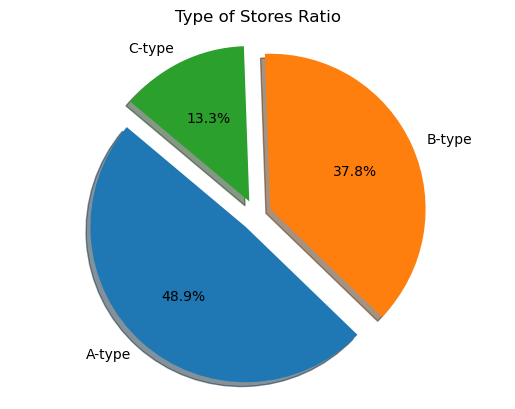

In [138]:
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100]
i_labels = 'A-type','B-type','C-type'
plt.pie(sizes,labels=i_labels,autopct='%1.1f%%',explode=explode,shadow=True, startangle=140)
plt.title('Type of Stores Ratio')
plt.axis('equal')
plt.show()

### the box plot of each type of store w.r.t to size

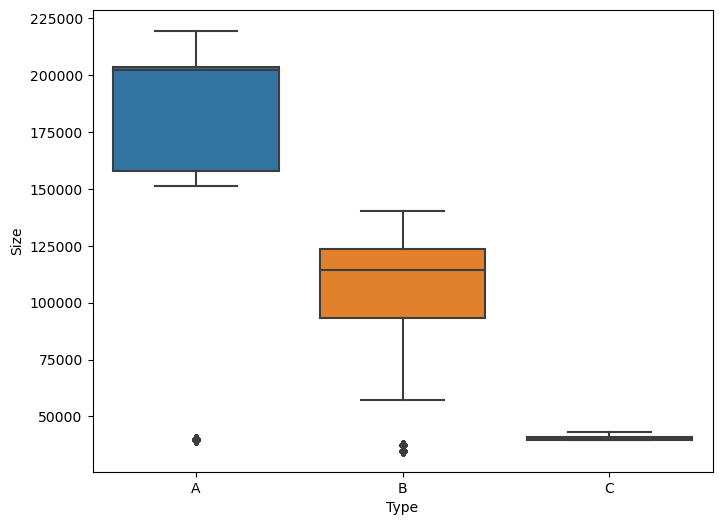

In [139]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=train)
plt.show()

- from pie chart and box plot, it is showed type A has stires of largest size, then B and finally C

## size has to do anything with weekly sales.

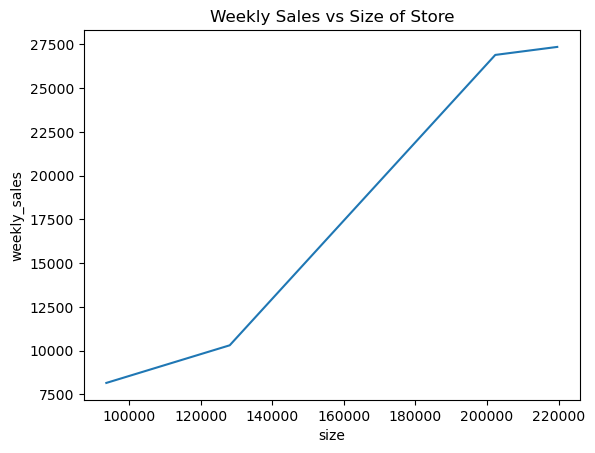

In [140]:
grouped_1=train.groupby('Size')
weekly_sales=list(grouped_1.mean()['Weekly_Sales'])
sq = (grouped_1['Size'].unique())
size = [i[0] for i in list(sq)]
weekly_sales = [x for _,x in sorted(zip(size,weekly_sales))]
size.sort()
sizes = []
for i in range(len(size)):
    if(i+1 == len(size)):
        sizes.append(size[i])
    elif ((i+1)%10==0):
        sizes.append(size[i])
weekly_sale=[]
for i in range(len(size)):
    if(i+1 == len(size)):
        weekly_sale.append(weekly_sales[i])
    elif ((i+1)%10==0):
        weekly_sale.append(weekly_sales[i])
weekly_sales
plt.plot(sizes, weekly_sale)
plt.title('Weekly Sales vs Size of Store')
plt.xlabel('size')
plt.ylabel('weekly_sales')
plt.show()

- through this line chart it can be seen that as size increases, weekly sales also increases.

## the sales of store for each type of store

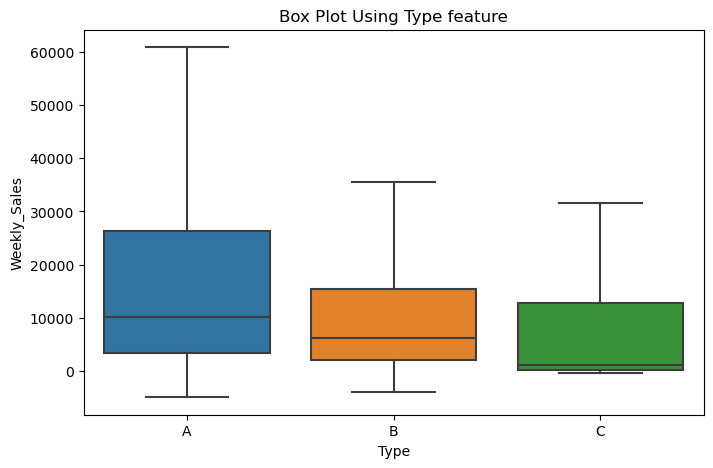

In [141]:
fig, ax = plt.subplots(figsize=(8, 5))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Type feature")
plt.show()

- through box plot ,we can see that median of each type of store decreases from left to right means from A store to C.
- So we can conclude that type is an import categorical feature to predict weekly sales. And plays role in increasing sales of a store.

NameError: name 'train_merged' is not defined

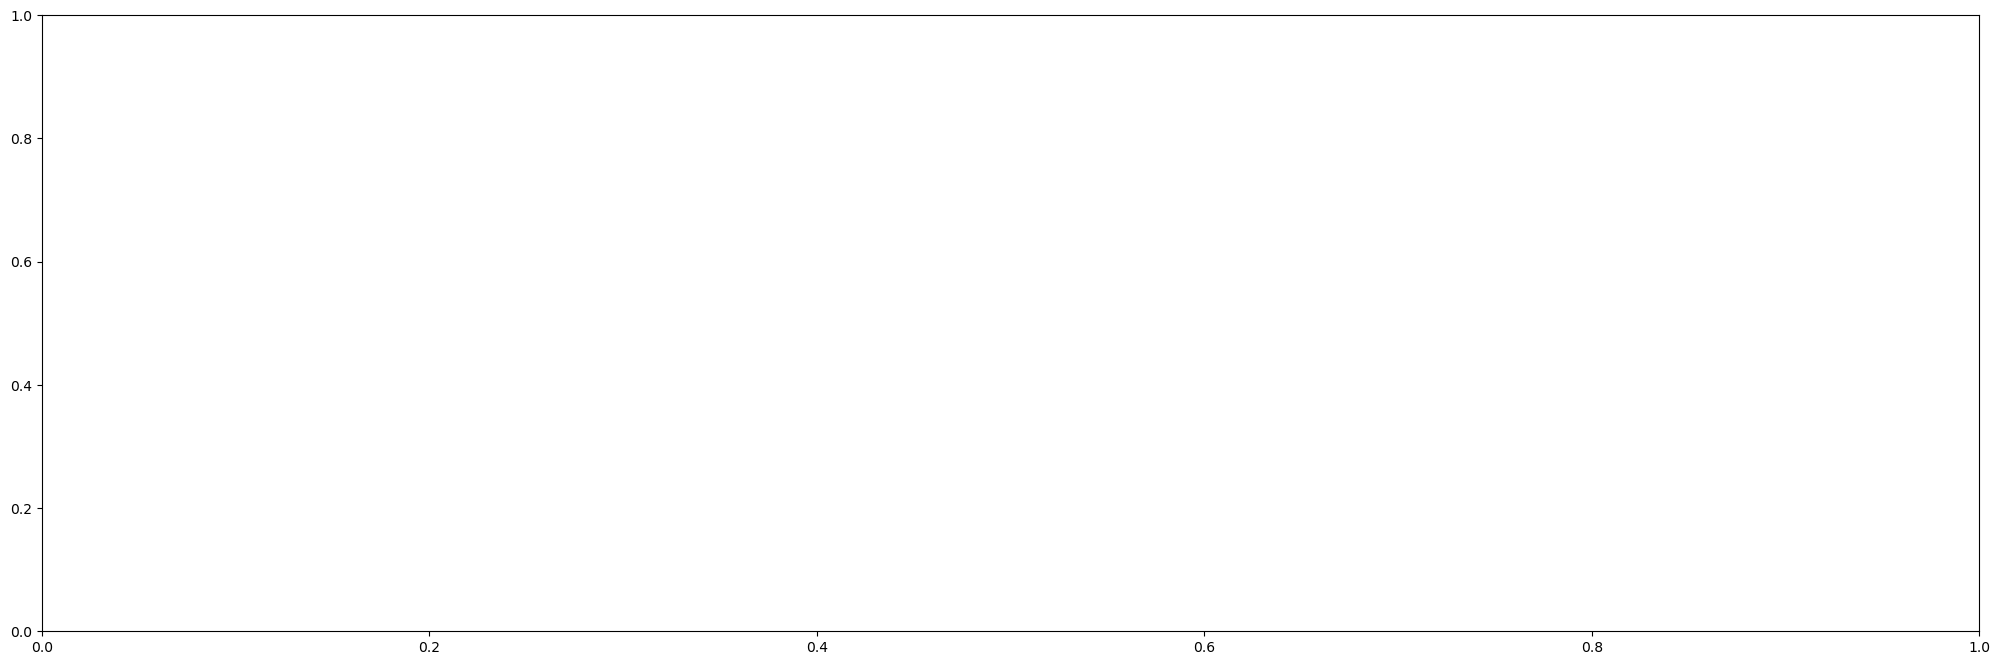

In [30]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x="Store",y='Weekly_Sales',data=train,showfliers=False, hue="Type")
plt.title("Box Plot Using Size feature")
plt.show()


- Store feature is an useful feature to predict sales. As it comprises of department, size or type and also region as well which was not provided in dataset.


## impact of holidays on sales of the store

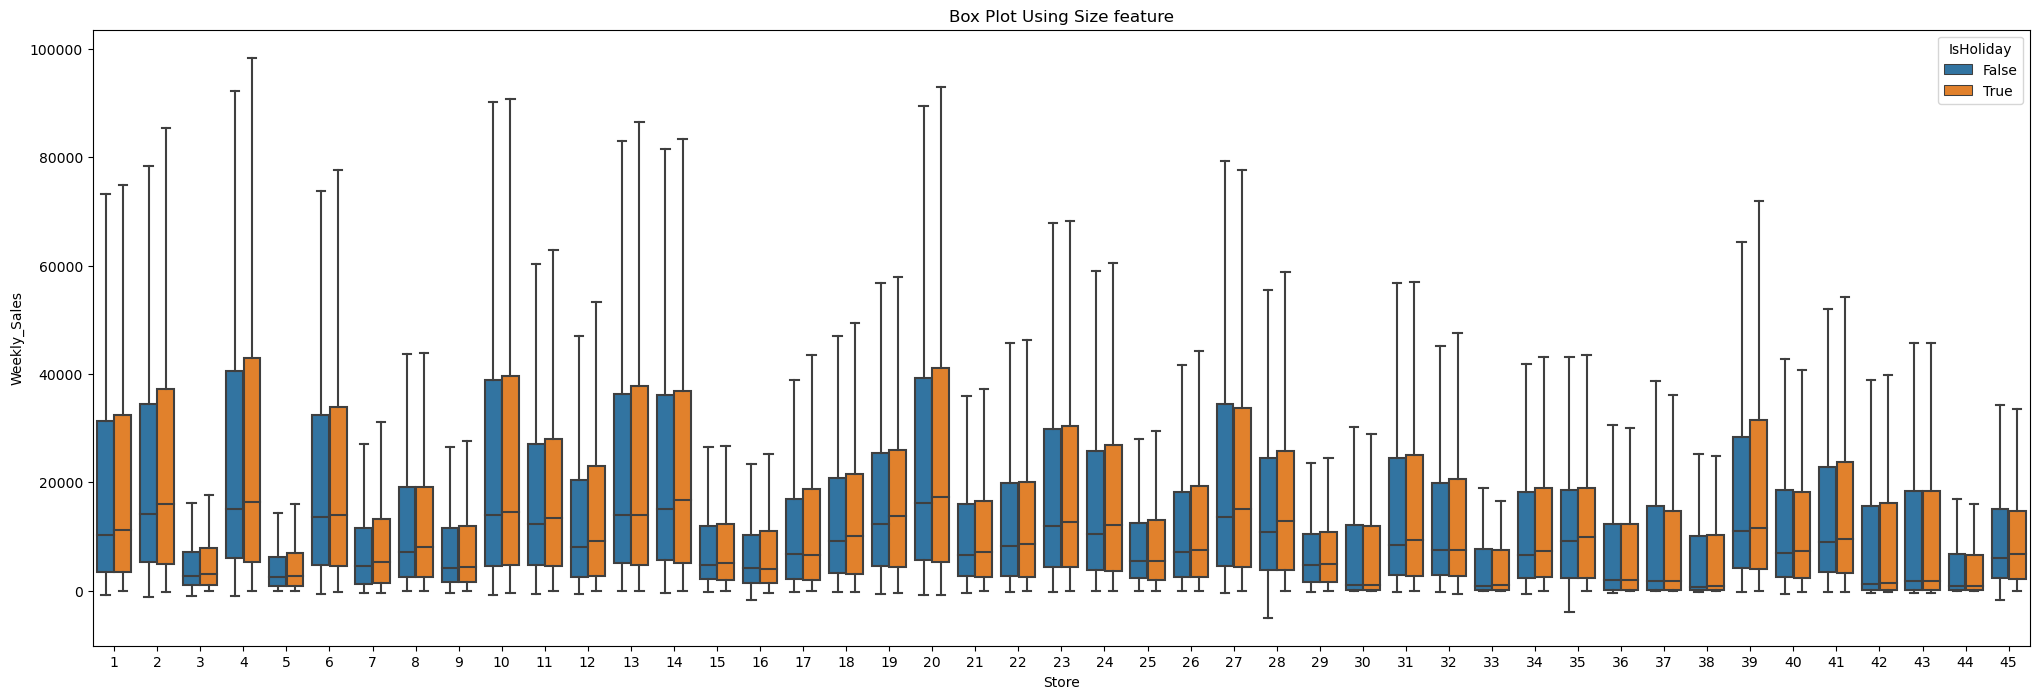

In [143]:

fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=train, showfliers=False, hue="IsHoliday")
plt.title("Box Plot Using Size feature")
plt.show()

- It can be seen that holidays has some impact on sales of store. for many store, sales have increased.

## the Department Feature and see the impacr of it on sales.

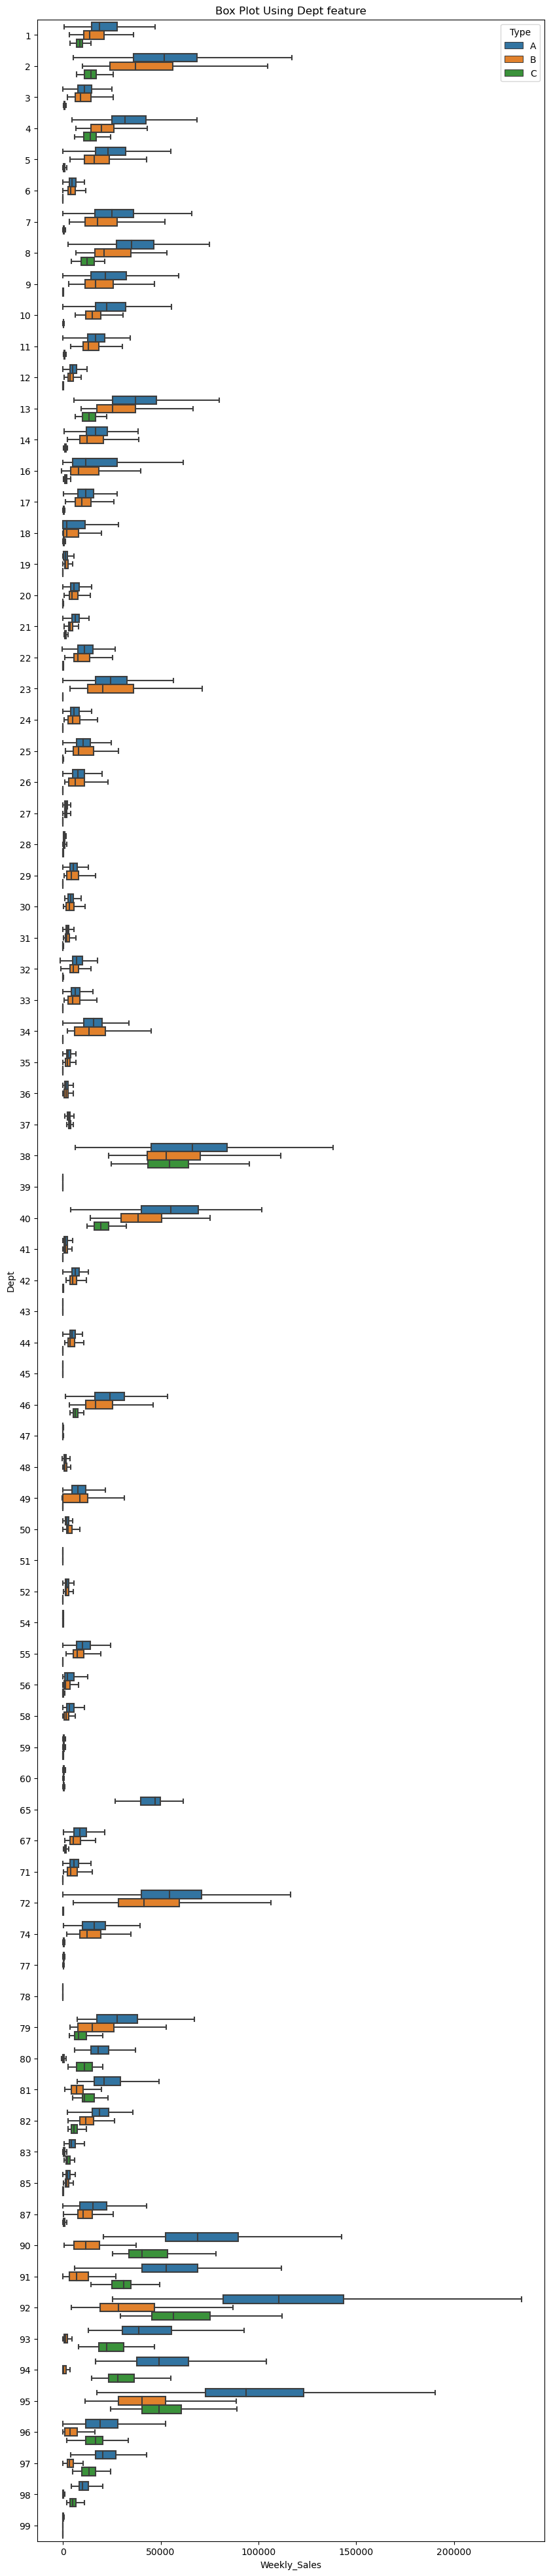

In [144]:
fig, ax = plt.subplots(figsize=(10, 50))
fig = sns.boxplot(y='Dept', x='Weekly_Sales', data=train, showfliers=False, hue="Type",orient="h") 
plt.title("Box Plot Using Dept feature")
plt.show()

- Department can be a factor in predicting sales as it can be seen through box plot that every department has a different sales than other. Further,  department factor is also correlated with type as it can be seen that type A has higher sales in most of the department.

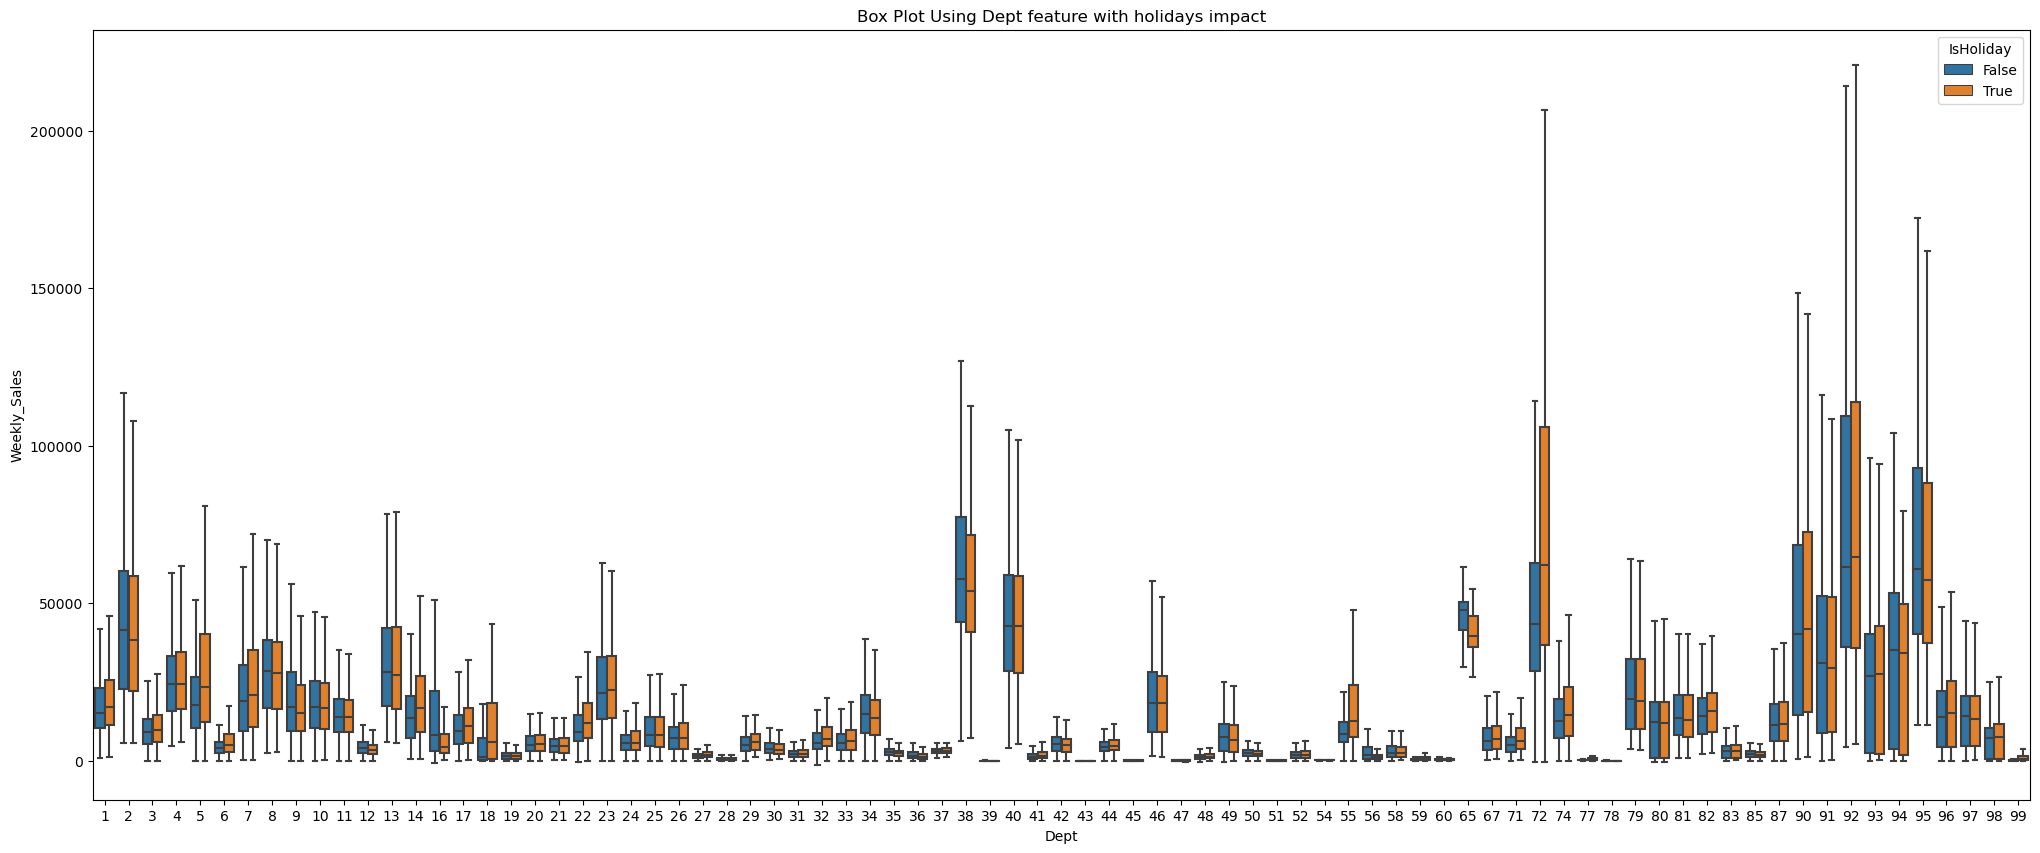

In [145]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=train, showfliers=False, hue="IsHoliday")
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

- As it can be seen through Box plot, there is not much to conclude from it except that in most department sales increase but in some it even get lesser than normal week which can tell that some department  are not useful in holidays season.


## create Month end feature and month start
-  becasue people tend to have less salary at the end of month and at month start people get salary so let's check if has any impact on sales

In [146]:
train['Is_month_end'] = np.where(train.Day > 22, 1, 0)
train['Is_month_start'] = np.where(train.Day<7,1,0)
train['Is_month_end'] = train['Is_month_end'].astype('bool')
train['Is_month_start'] = train['Is_month_start'].astype('bool')

In [147]:
print("Correlation of Is_month_end feature with weekly_sales")
print(correlation_ratio(train['Is_month_end'],train['Weekly_Sales']))
print(50*'*')
print("Correlation of Is_month_start feature with weekly_sales")
print(correlation_ratio(train['Is_month_start'],train['Weekly_Sales']))
print(50*'*')

Correlation of Is_month_end feature with weekly_sales
5.109982375092706e-06
**************************************************
Correlation of Is_month_start feature with weekly_sales
1.919291806025242e-05
**************************************************


- Very less correlation between weekly_sales and These two features.

In [148]:
sales_month_end = train['Weekly_Sales'][train['Is_month_end']==1]
sales_not_month_end = train['Weekly_Sales'][train['Is_month_end']==0]
print("Mean of the sales in month end week: ", np.mean(sales_month_end))
print("Standard devition of the sales in month end week: ", np.std(sales_month_end))
print("Max sales in month end week: ", np.max(sales_month_end))
print("Mean of the sales other than month end week: ", np.mean(sales_not_month_end))
print("Standard devition of the sales other than month end week: ", np.std(sales_not_month_end))
print("Max sales other than month end week: ", np.max(sales_not_month_end))
print("*"*100)

Mean of the sales in month end week:  16063.668127620045
Standard devition of the sales in month end week:  23601.151162302966
Max sales in month end week:  693099.36
Mean of the sales other than month end week:  15949.275213958605
Standard devition of the sales other than month end week:  22356.130945246885
Max sales other than month end week:  293966.05
****************************************************************************************************


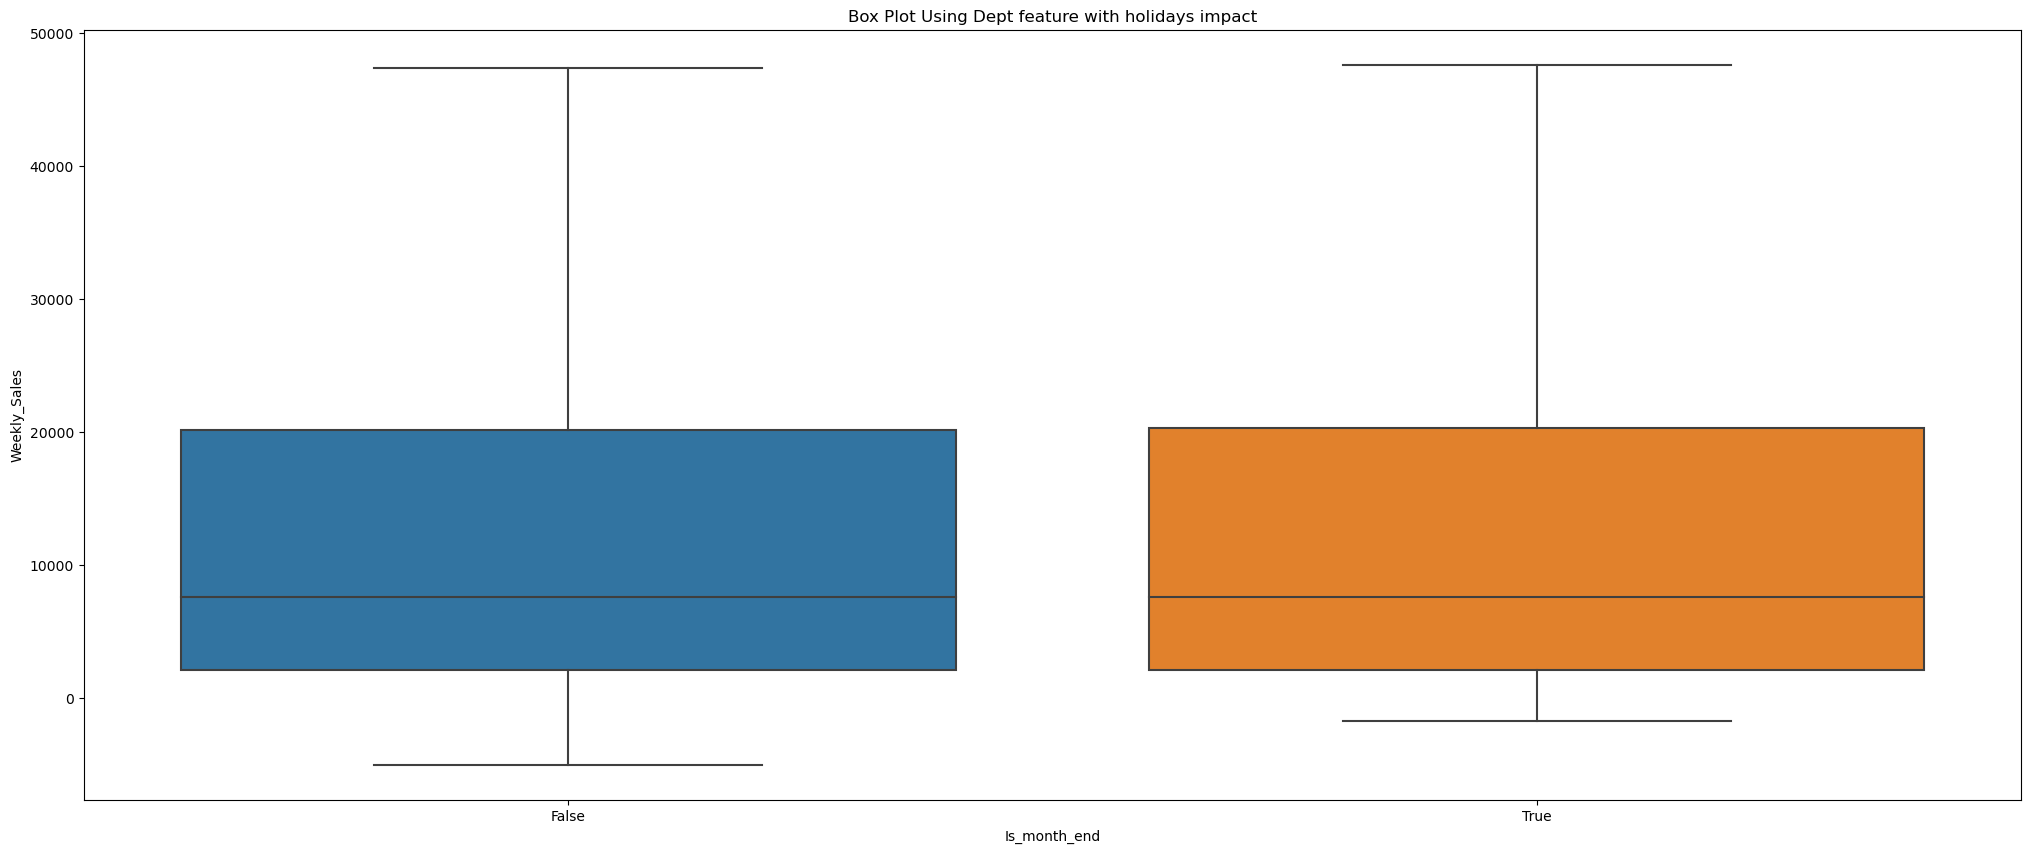

In [149]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Is_month_end', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

- if you see that month end have no impact on sales.So this feature is not useful.

In [150]:
sales_month_start = train['Weekly_Sales'][train['Is_month_start']==1]
sales_not_month_start = train['Weekly_Sales'][train['Is_month_start']==0]
print("Mean of the sales in month start week: ", np.mean(sales_month_start))
print("Standard devition of the sales in month start week: ", np.std(sales_month_start))
print("Max sales in month start week: ", np.max(sales_month_start))
print("Mean of the sales other than month start week: ", np.mean(sales_not_month_start))
print("Standard devition of the sales other than month start week: ", np.std(sales_not_month_start))
print("Max sales other than month start week: ", np.max(sales_not_month_start))
print("*"*100)


Mean of the sales in month start week:  16178.467199542049
Standard devition of the sales in month start week:  22668.76256306826
Max sales in month start week:  293966.05
Mean of the sales other than month start week:  15931.05940687573
Standard devition of the sales other than month start week:  22721.66187138905
Max sales other than month start week:  693099.36
****************************************************************************************************


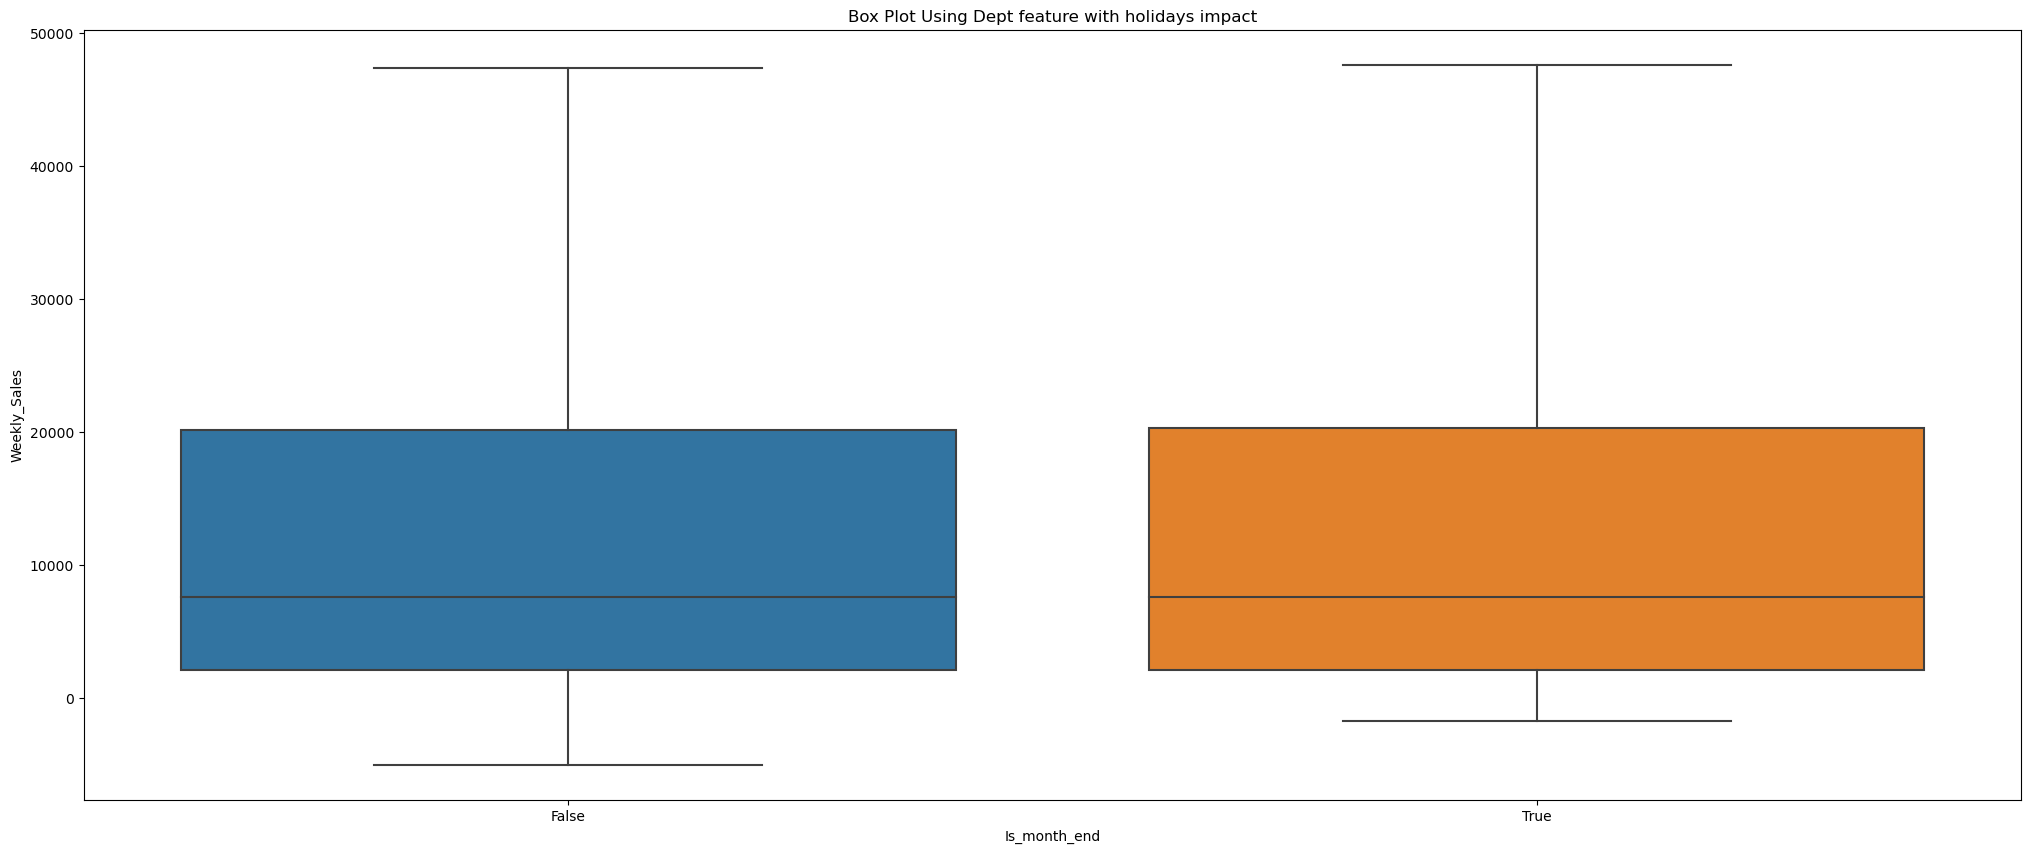

In [151]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Is_month_end', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

- This feature is also not useful

## deep dive into  weekly_sales feature nature

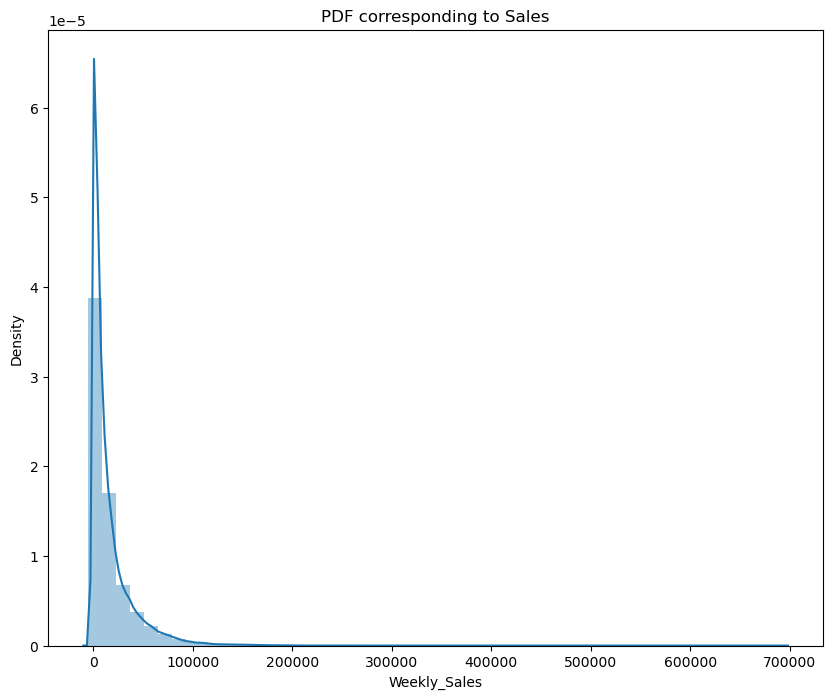

In [152]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(train['Weekly_Sales'])
plt.title("PDF corresponding to Sales")
plt.show()

- Most of the week have sales between 0 to 30000.

[9.56244515e-01 3.93054534e-02 4.09659131e-03 2.49068957e-04
 4.50696207e-05 4.26975354e-05 7.11625590e-06 0.00000000e+00
 0.00000000e+00 9.48834120e-06]
[ -4988.94  64819.89 134628.72 204437.55 274246.38 344055.21 413864.04
 483672.87 553481.7  623290.53 693099.36]


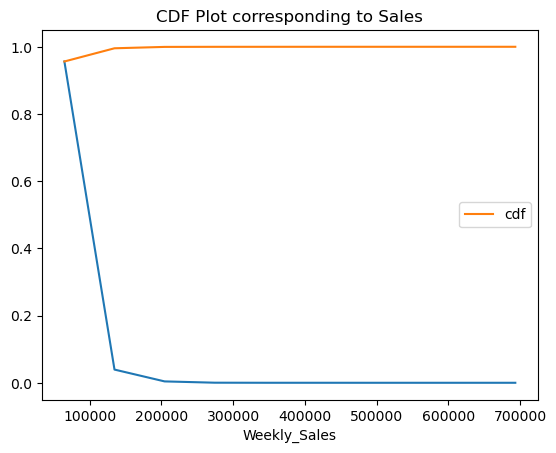

In [153]:
counts,bin_edges=np.histogram(train['Weekly_Sales'],bins=10,density=False)
pdf = counts/sum(counts)
print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Weekly_Sales')
plt.title("CDF Plot corresponding to Sales")
plt.legend([plot1],['cdf'])
plt.show()

- Almost 90 percent time sales are below 150000.

In [154]:
# It can be seen that the minimum salary is -4988 which and looking at the data there are 
# 1285 sales are negative.Sales can not be negative.So we'll remove them
train['Weekly_Sales'].min()
negative_sales = train[train['Weekly_Sales']<0]

## check the Markdown Values

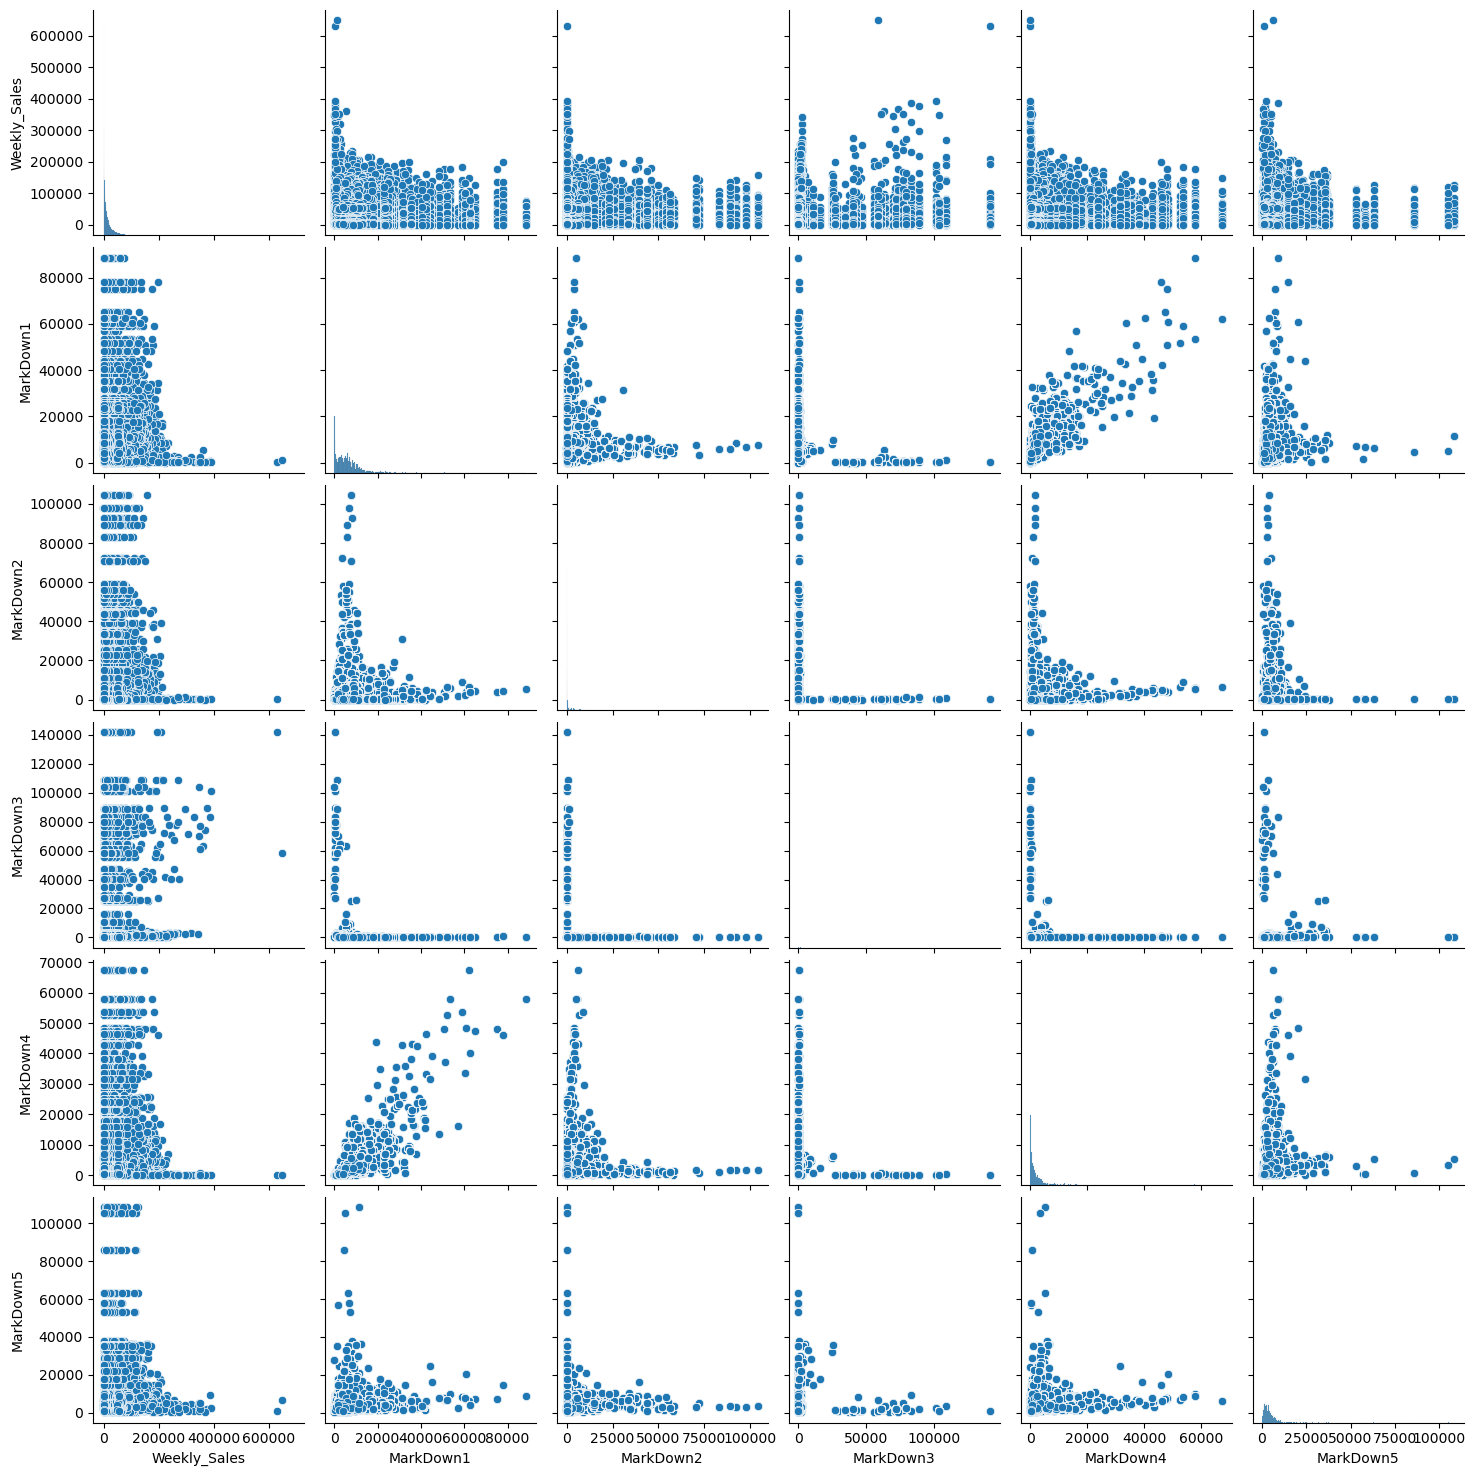

In [155]:
pair = sns.pairplot(train,vars=['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
plt.show()

- Markdown 1 and markdown 4 are correlated to some extent

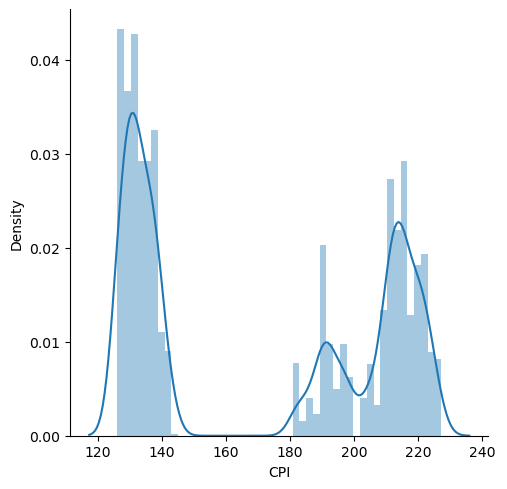

In [156]:
grid = sns.FacetGrid(train,size = 5).map(sns.distplot,"CPI").add_legend();
plt.show()

- between 150 to 170  value of CPI there is no datapoint.

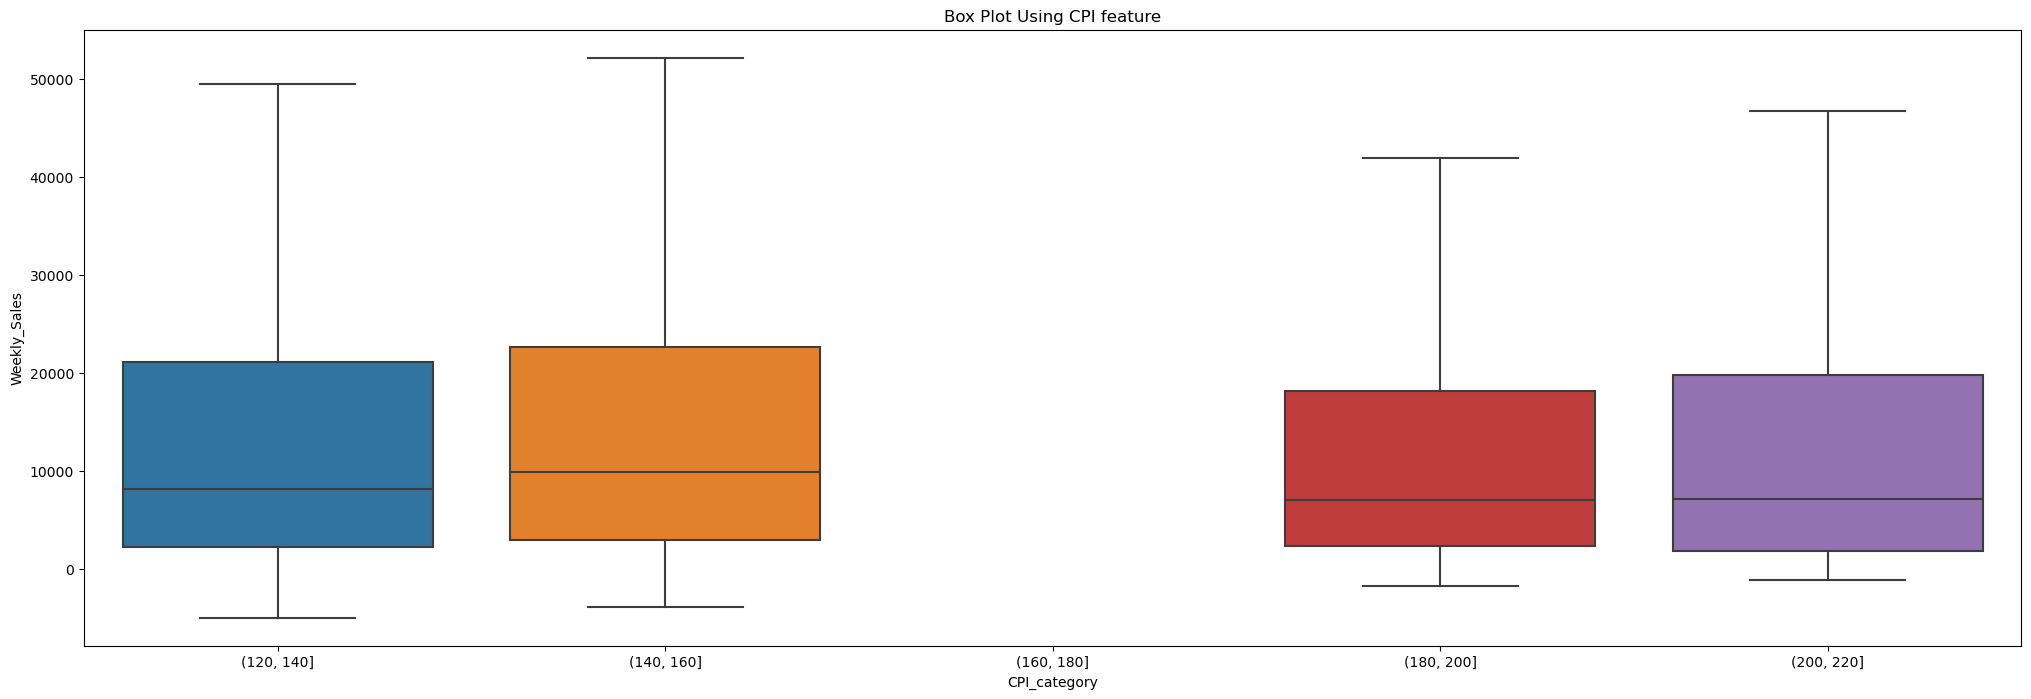

In [157]:
train['CPI_category'] = pd.cut(train['CPI'],bins=[120,140,160,180,200,220])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='CPI_category', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.show()

-  not much difference while change in the CPI during that period.

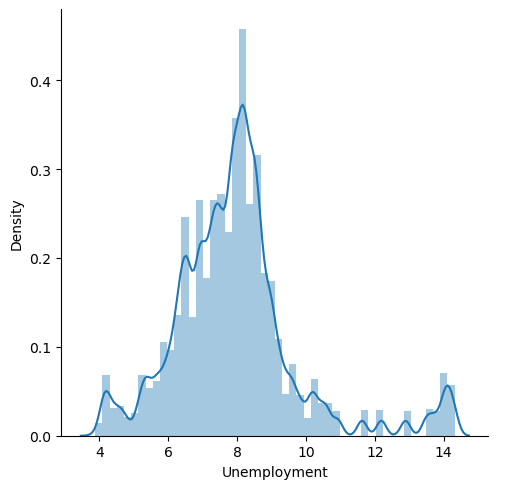

In [158]:
grid2 = sns.FacetGrid(train,size=5).map(sns.distplot,"Unemployment").add_legend()
plt.show()

- Most of the point lies when umployement rate is 8.

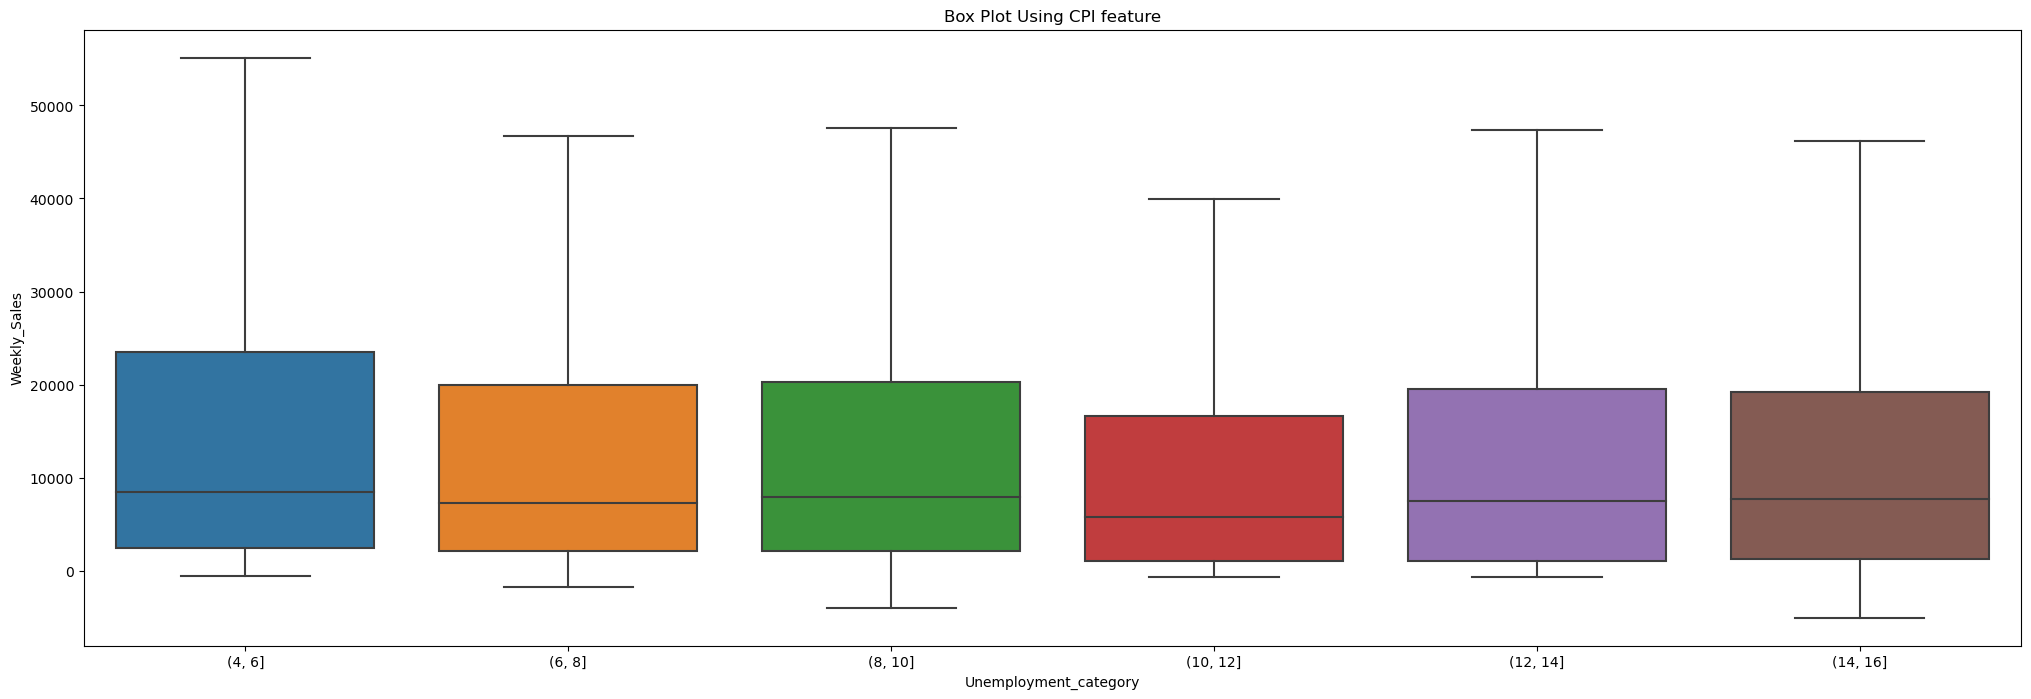

In [159]:
train['Unemployment_category'] = pd.cut(train['Unemployment'],bins=[4,6,8,10,12,14,16])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Unemployment_category', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.show()

-  Mean value of all box plot range are comparartively equal so it is not useful in determining sales of store.so it can be removed

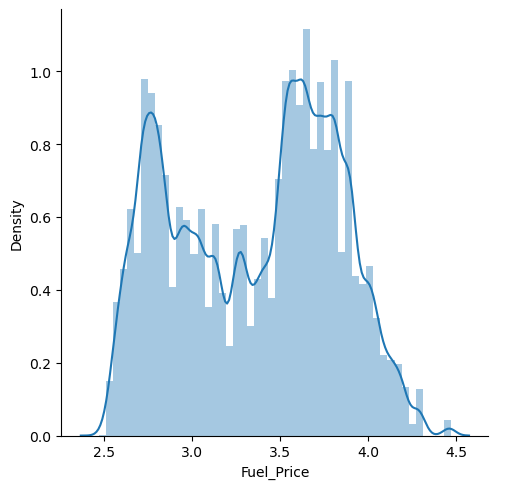

In [160]:
grid33 = sns.FacetGrid(train,size=5).map(sns.distplot,"Fuel_Price").add_legend();
plt.show()

- Here it looks no of datapoints are higher when fuel rate was between 3.5 to 4.0 and 2.5-3.0 .

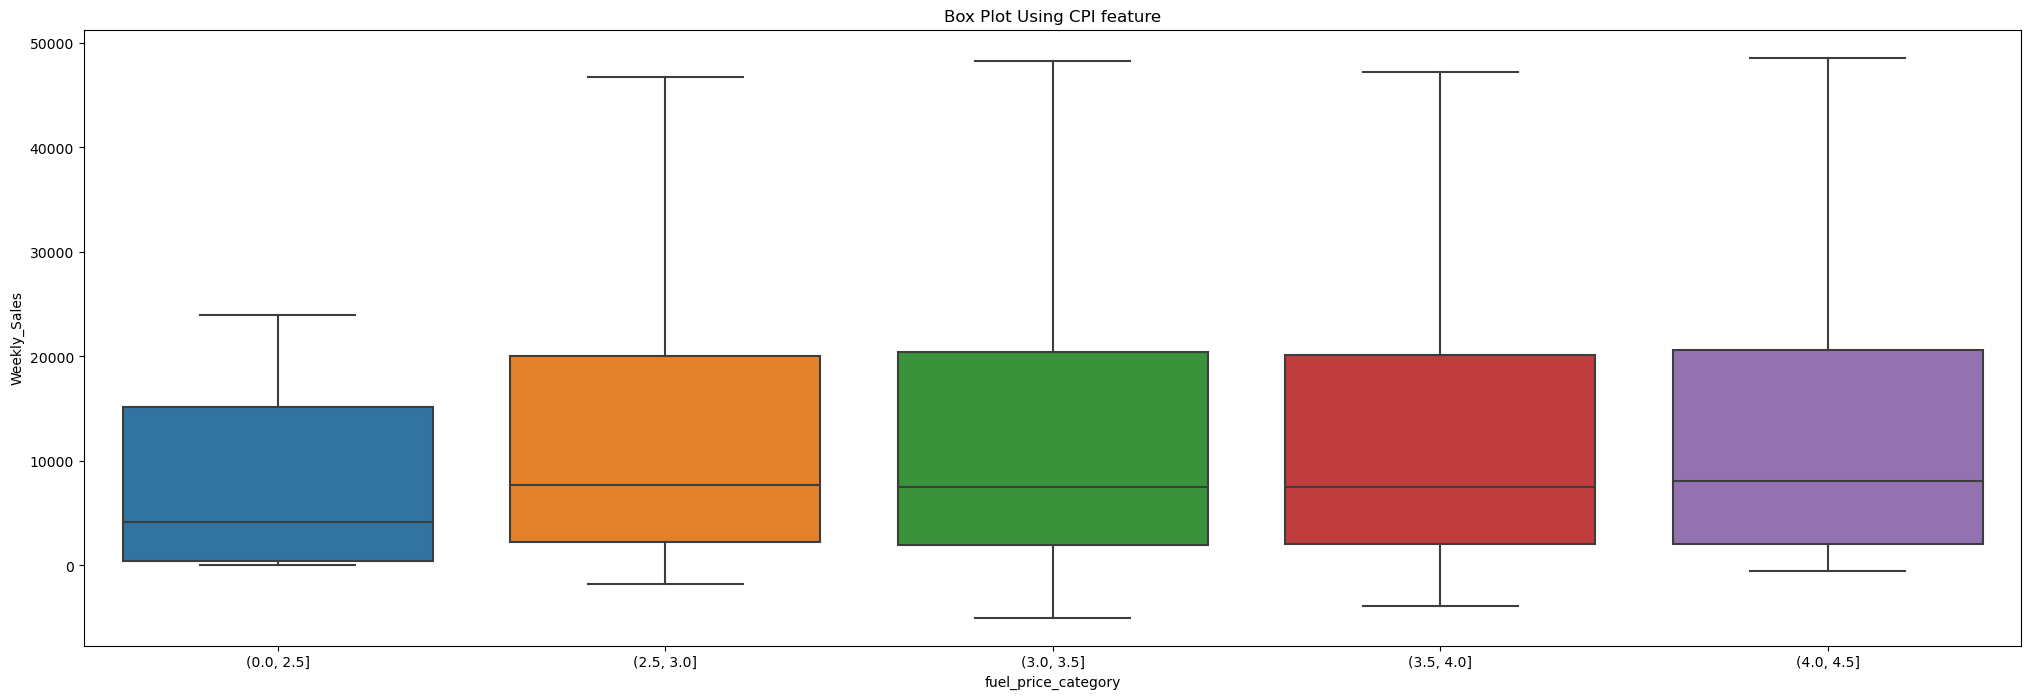

In [161]:
train['fuel_price_category'] = pd.cut(train['Fuel_Price'],bins=[0,2.5,3,3.5,4,4.5])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='fuel_price_category', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.show()

- Fuel price has very less impact on sales as there is no change in sales as price increasing.So this feature can also be removed.


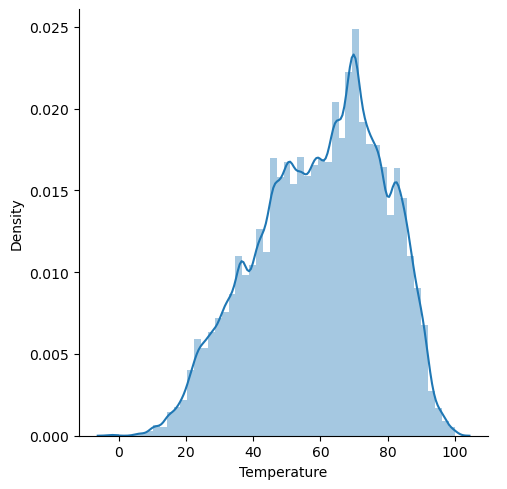

In [162]:
grid4 = sns.FacetGrid(train,size=5).map(sns.distplot,"Temperature").add_legend();
plt.show()

- through here it can be seen that most of the data point lies in 60-80 F temperatures

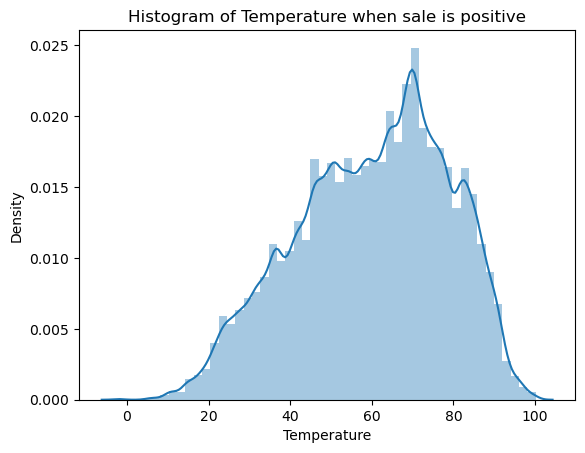

In [163]:
positive_temperature = train[train['Weekly_Sales']>0]['Temperature']
sns.distplot(positive_temperature)
plt.title("Histogram of Temperature when sale is positive")
plt.show()

- This graph is also telling the same thing that 60-80 F temperature have more number of times of sale.

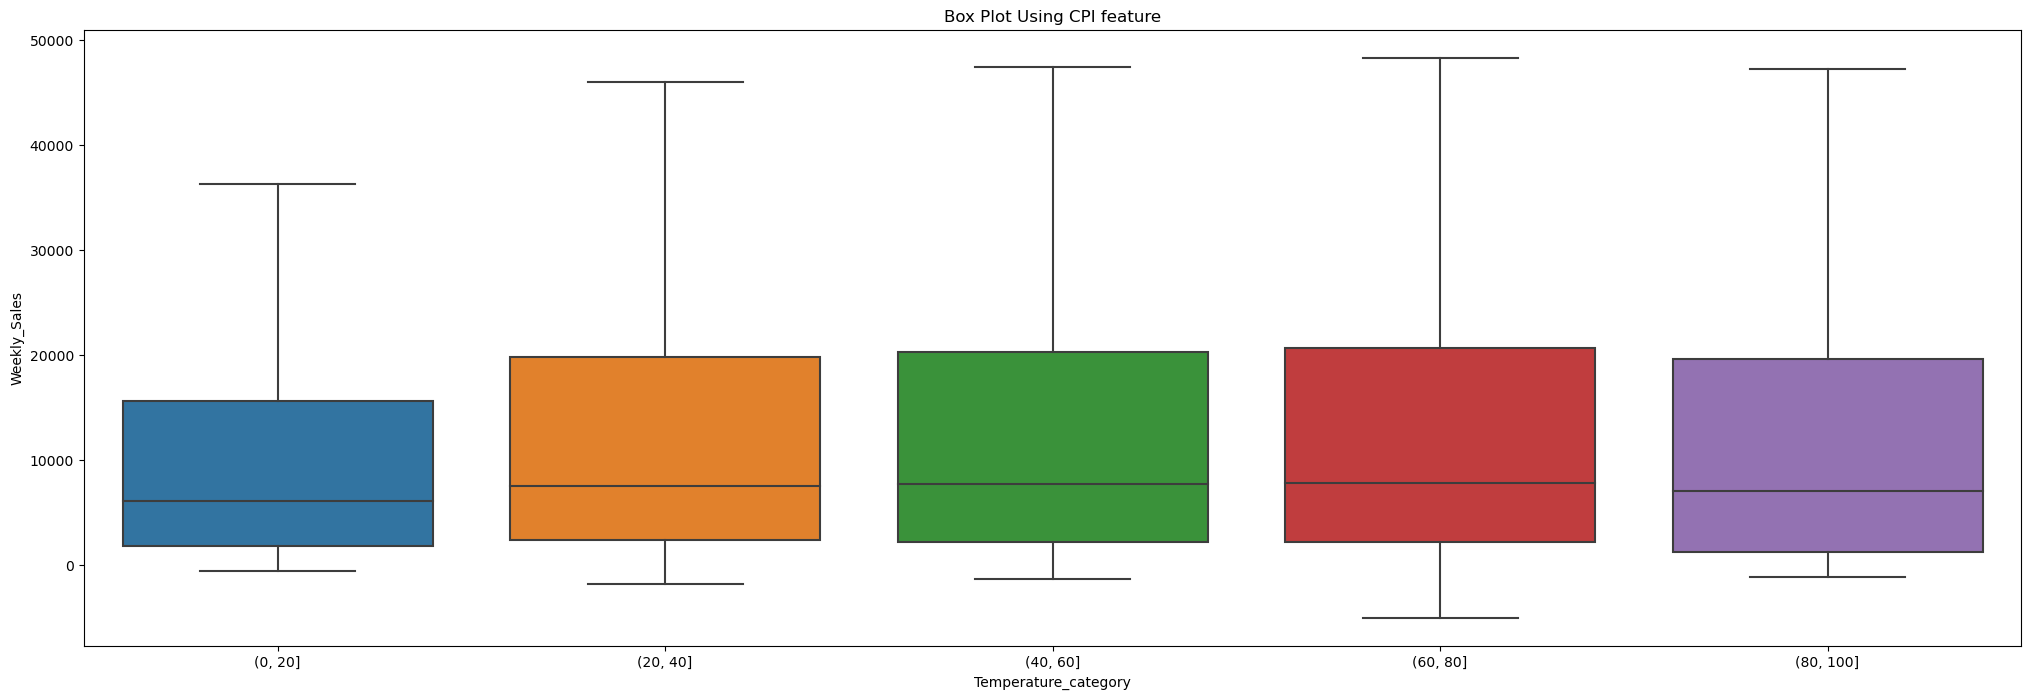

In [164]:
train['Temperature_category'] = pd.cut(train['Temperature'],bins=[0,20,40,60,80,100])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Temperature_category', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.show()

- here it seems 60-80 temperature have almost same sale as in other category of temperature.So this feature can also be removed.

## find more holidays and create a feature as no of holidays in that week

In [7]:
dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holidays_list=[] 
for index, row in train.iterrows():
    dat = train['Date'][index]
    dt=[]
    for i in range(0,5):
        dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
        dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
        if date in dt:
            count +=1
    holidays_list.append(count)
    
train['Holidays'] = np.array(holidays_list)

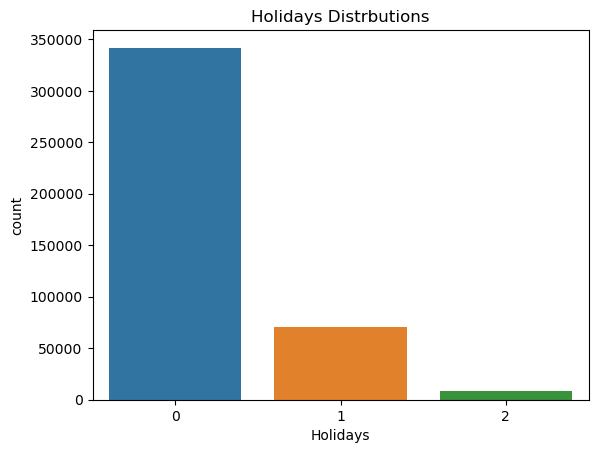

In [166]:
sns.countplot(train['Holidays']);
plt.title("Holidays Distrbutions")
plt.show()

- most of the week have no holidays. 

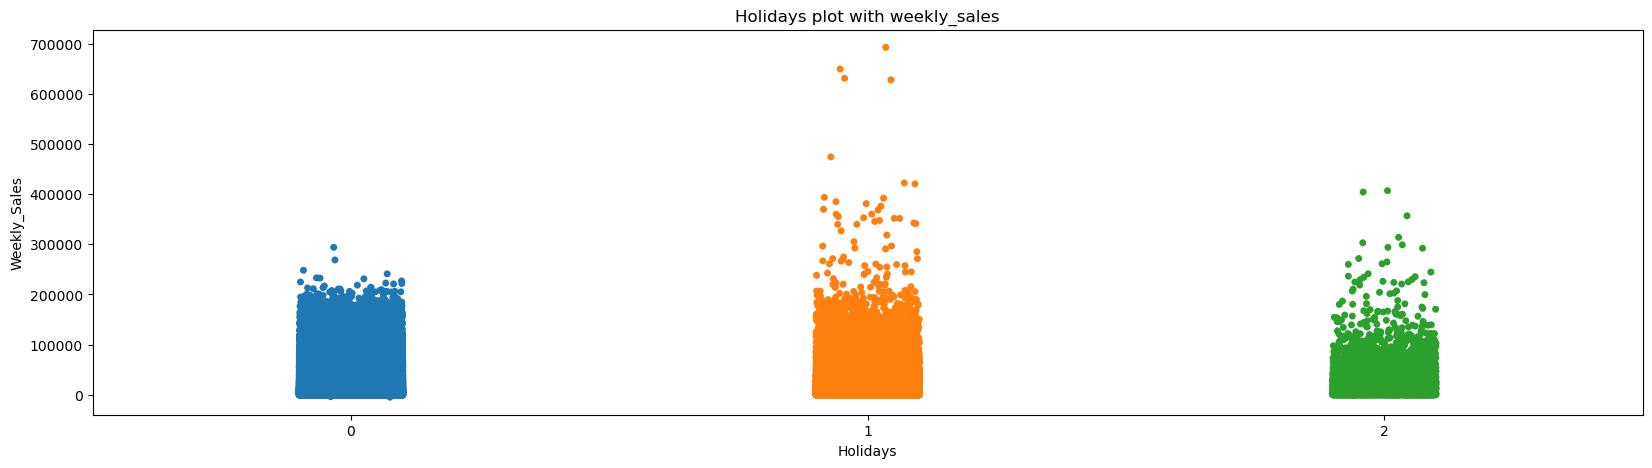

In [167]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.stripplot(y=train['Weekly_Sales'], x=train['Holidays'])
plt.title("Holidays plot with weekly_sales")
plt.show()

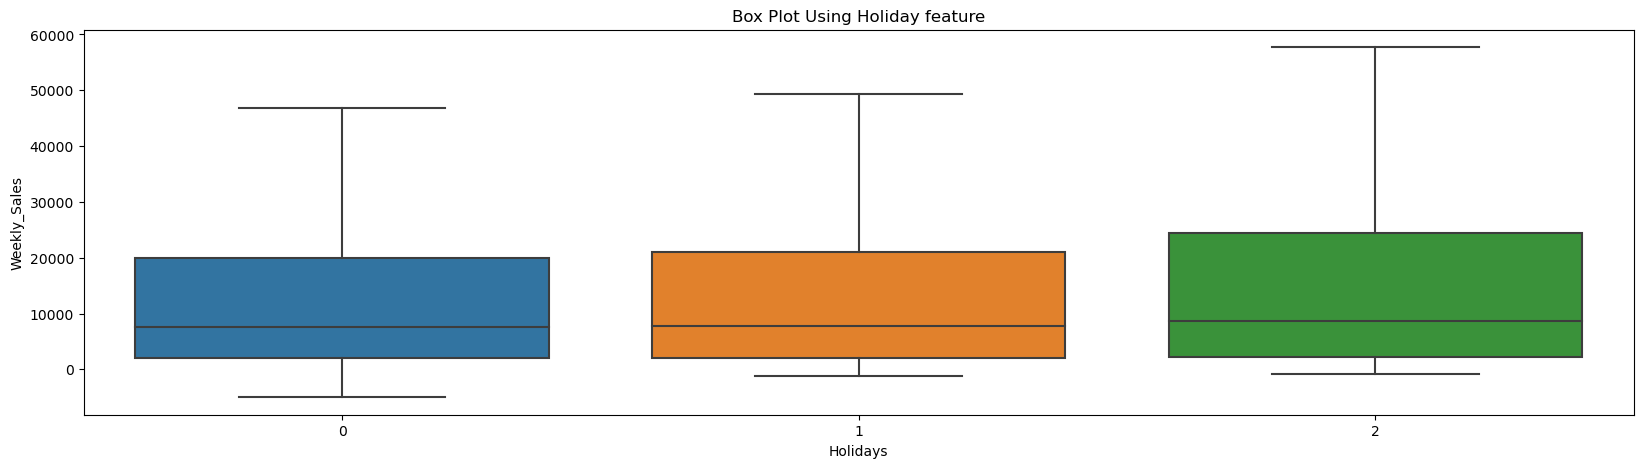

In [168]:
fig, ax = plt.subplots(figsize=(20, 5))
fig = sns.boxplot(x='Holidays', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Holiday feature")
plt.show()

- When Holidays are two in  a week then weekly_sales are bit higher

## create some more features from AutoEncoder 

In [169]:
train = train[train['Weekly_Sales']>0]
data = train[['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week', 'Day' ,'IsHoliday','Holidays']]
n_inputs = data.shape[1]
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes
X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.33, random_state=1)
t = StandardScaler()
t.fit(data)
train_data = t.transform(X_train)
test_data = t.transform(X_test)

In [170]:
#Computing Performance Metrics
def WMAE(dataset, real, predicted):
  
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [171]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print(WMAE(X_test,y_test, yhat))

1480.58


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/5
17597/17597 - 20s - loss: 0.2508 - val_loss: 0.0825 - 20s/epoch - 1ms/step
Epoch 2/5
17597/17597 - 18s - loss: 0.1596 - val_loss: 0.0697 - 18s/epoch - 1ms/step
Epoch 3/5
17597/17597 - 18s - loss: 0.1446 - val_loss: 0.0733 - 18s/epoch - 1ms/step
Epoch 4/5
17597/17597 - 18s - loss: 0.1400 - val_loss: 0.0828 - 18s/epoch - 1ms/step
Epoch 5/5
17597/17597 - 18s - loss: 0.1359 - val_loss: 0.0746 - 18s/epoch - 1ms/step


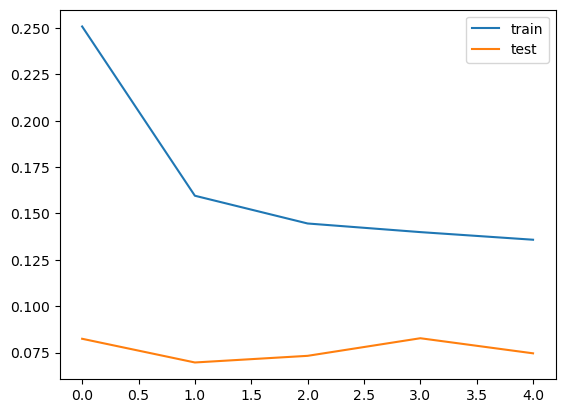

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [172]:
# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
encoder = Dense(n_inputs*2)(visible)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# encoder level 2
encoder = Dense(n_inputs)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)

# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

# fit the autoencoder model to reconstruct input
history = model.fit(train_data, train_data, epochs=5, batch_size=16, verbose=2, validation_data=(test_data,test_data))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)


In [173]:
X_train_encode = encoder.predict(train_data)
X_test_encode = encoder.predict(test_data)

tr_data = np.hstack((X_train, X_train_encode))
te_data = np.hstack((X_test,X_test_encode))

clf = RandomForestRegressor()
clf.fit(tr_data, y_train.values)
yhat = clf.predict(te_data)

print(WMAE(X_test,y_test, yhat))

4334/4334 [==============================] - 2s 513us/step
1675.57


- WMAE increases after using Autoencoder features increases which means model performance deteriorated.

In [174]:
g = train.groupby(["Month","Store"])
monthly_averages = g.aggregate({"Weekly_Sales":np.mean})
store_value=monthly_averages.loc[monthly_averages.groupby('Month')['Weekly_Sales'].idxmax()]
print("Stores which have highest value during that  Month: ")
store_value

Stores which have highest value during that  Month: 


,,Weekly_Sales
Month,Store,
1,4,26792.255620
2,20,30534.622526
3,14,28550.643923
4,14,29587.727856
5,14,29439.083763
6,20,30032.278419
7,20,28916.581834
8,4,29082.862586
9,20,28006.353978


- It can be seen that 3 stores are more prominent than all others. Store 20 has highest Sale during Thanksgiving and Christmas which were more impactful than Labour's Day and Super Bowl
- As we can see that thanksgiving and christmas are more impactful than other two.so every holiday has its own level of impact .So we can make a category of holidays as feature.

In [175]:
# This Function is creating a category where each holiday from all 4 holidays will be a seperate category.
def create_Holiday_Type(df):
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1
    
    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])
    
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

In [176]:
create_Holiday_Type(train)

In [177]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days,...,CPI,Unemployment,Is_month_end,Is_month_start,CPI_category,Unemployment_category,fuel_price_category,Temperature_category,Holidays,HolidayType
0,1.0,1.0,2010-02-05,24924.50,False,2010.0,2.0,5.0,5.0,0.0,...,211.096358,8.106,False,True,"(200, 220]","(8, 10]","(2.5, 3.0]","(40, 60]",0.0,-1.0
1,1.0,1.0,2010-02-12,46039.49,True,2010.0,2.0,6.0,12.0,7.0,...,211.242170,8.106,False,False,"(200, 220]","(8, 10]","(2.5, 3.0]","(20, 40]",0.0,0.0
2,1.0,1.0,2010-02-19,41595.55,False,2010.0,2.0,7.0,19.0,14.0,...,211.289143,8.106,False,False,"(200, 220]","(8, 10]","(2.5, 3.0]","(20, 40]",1.0,-1.0
3,1.0,1.0,2010-02-26,19403.54,False,2010.0,2.0,8.0,26.0,21.0,...,211.319643,8.106,True,False,"(200, 220]","(8, 10]","(2.5, 3.0]","(40, 60]",0.0,-1.0
4,1.0,1.0,2010-03-05,21827.90,False,2010.0,3.0,9.0,5.0,28.0,...,211.350143,8.106,False,True,"(200, 220]","(8, 10]","(2.5, 3.0]","(40, 60]",0.0,-1.0


In [178]:
train.isnull().mean()

Store                    0.000000
Dept                     0.000000
Date                     0.000000
Weekly_Sales             0.000000
IsHoliday                0.000000
Year                     0.000000
Month                    0.000000
Week                     0.000000
Day                      0.000000
n_days                   0.000000
Type                     0.000000
Size                     0.000000
Temperature              0.000000
Fuel_Price               0.000000
MarkDown1                0.642607
MarkDown2                0.736076
MarkDown3                0.674805
MarkDown4                0.679881
MarkDown5                0.640827
CPI                      0.000000
Unemployment             0.000000
Is_month_end             0.000000
Is_month_start           0.000000
CPI_category             0.092760
Unemployment_category    0.000683
fuel_price_category      0.000000
Temperature_category     0.000374
Holidays                 0.000000
HolidayType              0.000000
dtype: float64

- Through this you can see that Markdown values have high percentage of Nan values.
- As Markdown Values event precede the Holidays so there could be an impact of them on Weekly_Sales.So simply giving 0 or removing these column could lose some information. So better let machine learning model learn the pattern hiiden in it then fill the null values.


In [179]:
#here we are creating Markdown features copies to find the Nan values later
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [180]:
missing_columns = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
for feature in missing_columns:
    train[feature + '_imp'] = train[feature]
    train = random_imputation(train, feature)
y = pd.get_dummies(train.Type, prefix='Type')
train = pd.concat([train, y], axis=1)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days,...,Holidays,HolidayType,MarkDown1_imp,MarkDown2_imp,MarkDown3_imp,MarkDown4_imp,MarkDown5_imp,Type_A,Type_B,Type_C
0,1.0,1.0,2010-02-05,24924.50,False,2010.0,2.0,5.0,5.0,0.0,...,0.0,-1.0,5799.00,49.02,99.57,4874.69,1736.91,1,0,0
1,1.0,1.0,2010-02-12,46039.49,True,2010.0,2.0,6.0,12.0,7.0,...,0.0,0.0,3038.67,11.76,2.16,90.50,5588.33,1,0,0
2,1.0,1.0,2010-02-19,41595.55,False,2010.0,2.0,7.0,19.0,14.0,...,1.0,-1.0,4783.00,7982.96,3.34,167.56,6418.36,1,0,0
3,1.0,1.0,2010-02-26,19403.54,False,2010.0,2.0,8.0,26.0,21.0,...,0.0,-1.0,3221.25,1785.29,197.48,2524.07,4606.24,1,0,0
4,1.0,1.0,2010-03-05,21827.90,False,2010.0,3.0,9.0,5.0,28.0,...,0.0,-1.0,8501.55,7556.01,10.25,5974.36,2565.13,1,0,0


In [181]:
data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    data["Det" + feature] = train[feature + "_imp"]
    column_list = list(set(train.columns) - set(missing_columns) \
    - {feature + '_imp'} - {'Date'} -{'Type'} \
    - {'Temperature_category'} - {'Unemployment_category'}\
    - {'fuel_price_category'} - {'CPI_category'})

    model = LinearRegression()
    model.fit(X = train[column_list], y = train[feature + '_imp'])

    predict = model.predict(train[column_list])
    std_error = (predict[train[feature].notnull()] - train.loc[train[feature].notnull(), feature + '_imp']).std()
    
    random_predict = np.random.normal(size = train[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    data.loc[(train[feature].isnull()) & (random_predict > 0), "det" + feature] = random_predict[(train[feature].isnull()) & 
                                                                            (random_predict > 0)]

In [182]:
train.isnull().mean()

Store                    0.000000
Dept                     0.000000
Date                     0.000000
Weekly_Sales             0.000000
IsHoliday                0.000000
Year                     0.000000
Month                    0.000000
Week                     0.000000
Day                      0.000000
n_days                   0.000000
Type                     0.000000
Size                     0.000000
Temperature              0.000000
Fuel_Price               0.000000
MarkDown1                0.642607
MarkDown2                0.736076
MarkDown3                0.674805
MarkDown4                0.679881
MarkDown5                0.640827
CPI                      0.000000
Unemployment             0.000000
Is_month_end             0.000000
Is_month_start           0.000000
CPI_category             0.092760
Unemployment_category    0.000683
fuel_price_category      0.000000
Temperature_category     0.000374
Holidays                 0.000000
HolidayType              0.000000
MarkDown1_imp 

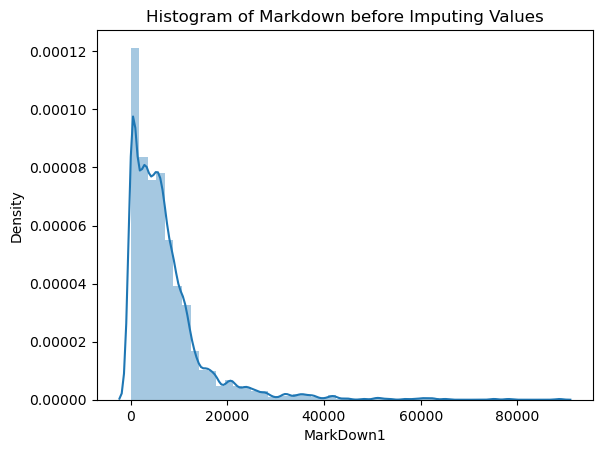

In [183]:
sns.distplot(train['MarkDown1'])
plt.title("Histogram of Markdown before Imputing Values")
plt.show()

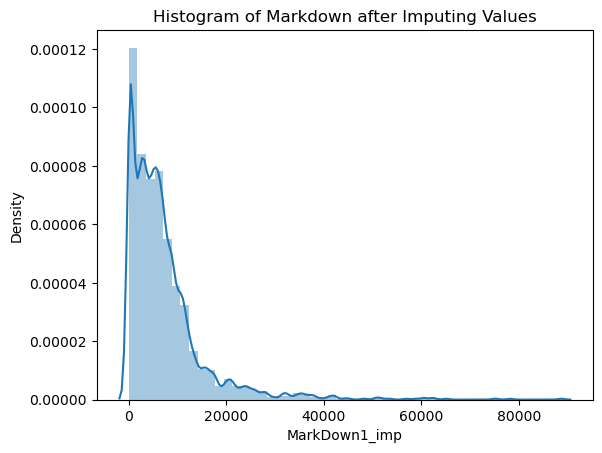

In [184]:
sns.distplot(train['MarkDown1_imp'])
plt.title("Histogram of Markdown after Imputing Values")
plt.show()

- Distrbutions are almost same

In [185]:
train["MarkDown1"] = train['MarkDown1_imp']
train["MarkDown2"] = train['MarkDown2_imp']
train["MarkDown3"] = train['MarkDown3_imp']
train["MarkDown4"] = train['MarkDown4_imp']
train["MarkDown5"] = train['MarkDown5_imp']

train=train.drop(['MarkDown1_imp', 'MarkDown2_imp', 'MarkDown3_imp', 'MarkDown4_imp', 'MarkDown5_imp', 'Type_A', 'Type_B', 'Type_C'], axis=1)

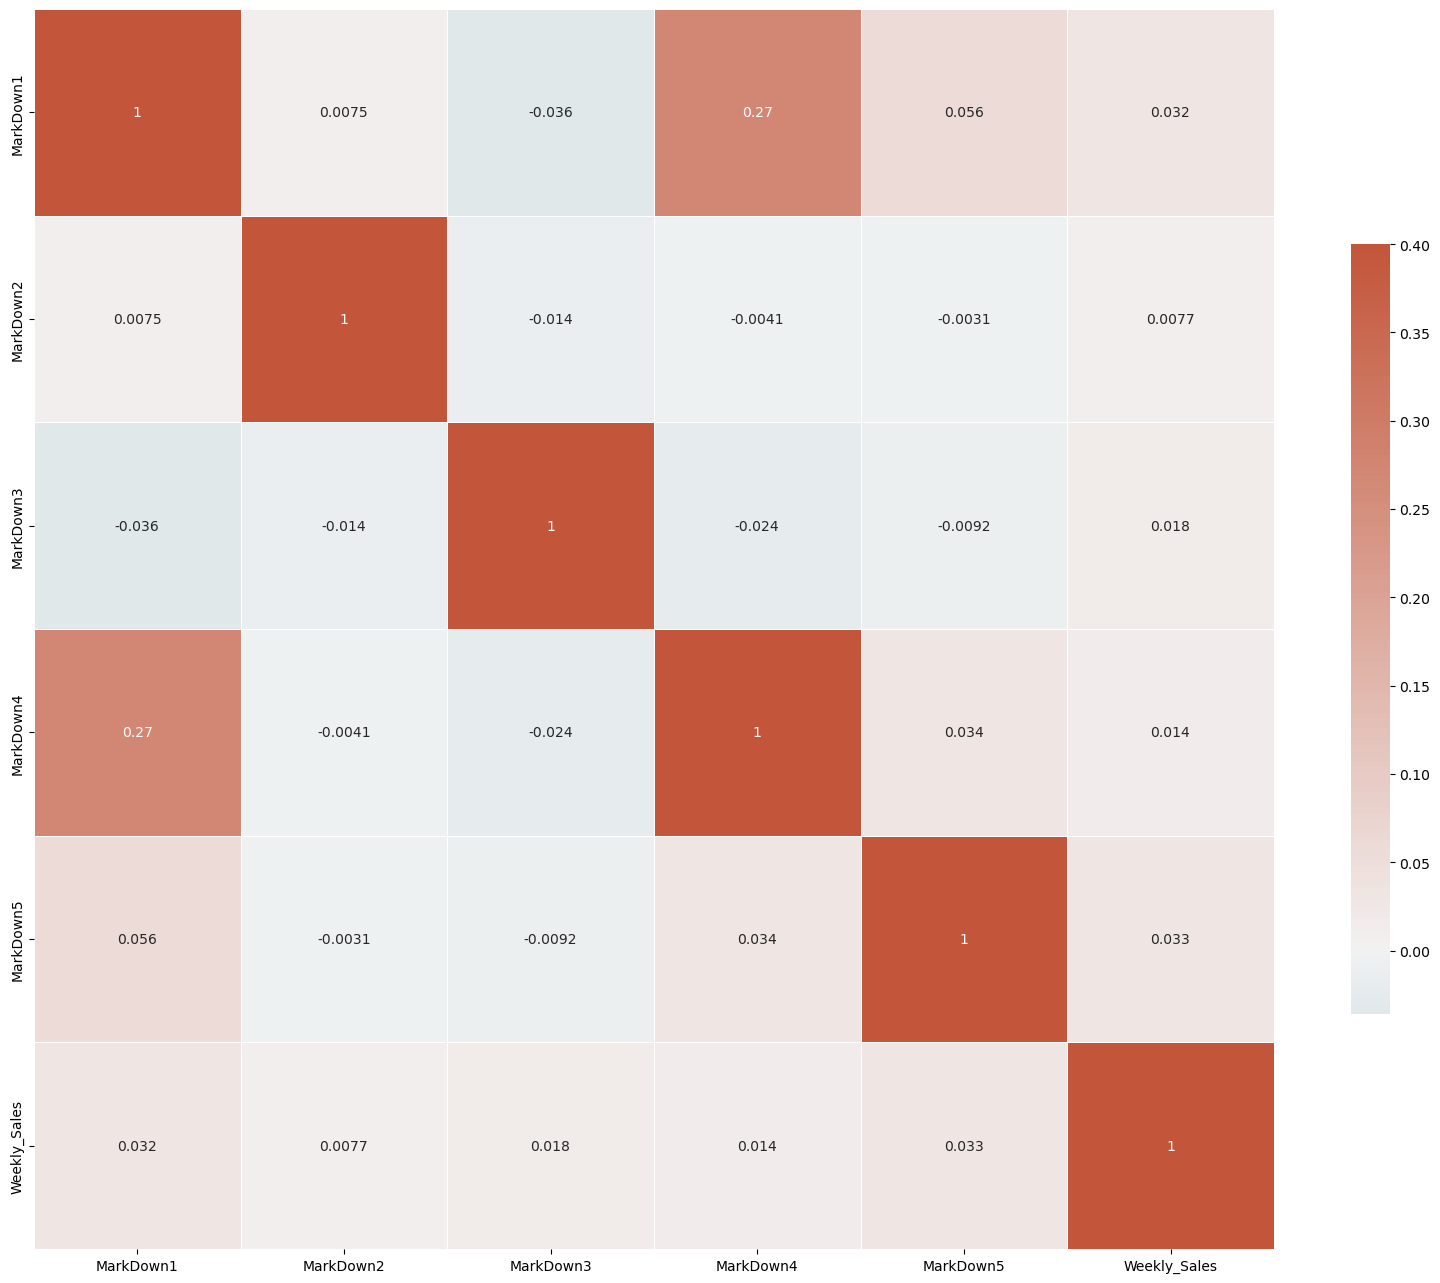

In [186]:
data = pd.concat([train['MarkDown1'],train['MarkDown2'],train['MarkDown3'],train['MarkDown4'],
                  train['MarkDown5'],train['Weekly_Sales']], axis=1)
corr = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.4, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

- Now Markdown Values are very less correlated to Weekly_sales .And markdown 1 and markdown4 are also higly correlated .So We can drop them

## Create the most Basic model(Mean and Median) Model and check It's performance So that When we create Machine Learning model we have the most basic model to compare with

In [187]:
Mean = np.mean(train['Weekly_Sales'])
predicted_value  = np.full((train.shape[0]), Mean)
print("Model Performance(WMAE) of Mean Model: ",WMAE(train,train['Weekly_Sales'], predicted_value))

Model Performance(WMAE) of Mean Model:  15350.22


In [188]:

Mean = np.median(train['Weekly_Sales'])
predicted_value  = np.full((train.shape[0]), Mean)
print("Model Performance(WMAE) of Median Model: ",WMAE(train,train['Weekly_Sales'], predicted_value))

Model Performance(WMAE) of Median Model:  13625.26


## Creating dateset for training purpopse

In [189]:
train = train[train['Weekly_Sales']>0]
data = train[['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week', 'Day','n_days' ,'IsHoliday','Holidays','HolidayType','CPI']]
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes

In [190]:
X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
t = StandardScaler()
t.fit(X_train)
train_data = t.transform(X_train)
test_data = t.transform(X_test)

## Creating Dataset for Testing

In [191]:
create_Holiday_Type(test)

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Week']=test['Date'].dt.week
test['Day']=test['Date'].dt.day
test['n_days']=(test['Date'].dt.date-train['Date'].dt.date.min()).apply(lambda x:x.days)

test = test.merge(stores, on = ['Store', 'Date', 'IsHoliday'], how = 'left')

dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holidays_list_test=[] 
for index, row in test.iterrows():
    dat = row['Date']
    dt=[]
    for i in range(0,5):
      dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
      dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
      if date in dt:
         count +=1
    holidays_list_test.append(count)
 
test['Holidays'] = np.array(holidays_list_test)

data_test = test[['Store', 'Size', 'Dept', 'Month','Type', 'Year','Week', 'Day','n_days' ,'IsHoliday','Holidays','HolidayType','CPI']]
data_test['Type'] = data_test['Type'].astype('category')
data_test['Type'] = data_test['Type'].cat.codes

# Model

In [192]:
model_list = {'linear regression':SGDRegressor(),'SVR':SGDRegressor(loss = 'epsilon_insensitive'),
              'RidgeCV':RidgeCV(),'ElasticNet':ElasticNet(),
              'RandomForest':RandomForestRegressor(),'XGboost':lgb.LGBMRegressor()}

for  model_name,model in model_list.items():
     model.fit(X_train,y_train)
     predicted = model.predict(X_test)
     print('WMAE score of ',model_name,' : ',WMAE(X_test,y_test,predicted))
     print(100*'-')

WMAE score of  linear regression  :  1.1915029685973896e+18
----------------------------------------------------------------------------------------------------
WMAE score of  SVR  :  411769.22
----------------------------------------------------------------------------------------------------
WMAE score of  RidgeCV  :  313842.6
----------------------------------------------------------------------------------------------------
WMAE score of  ElasticNet  :  14743.65
----------------------------------------------------------------------------------------------------
WMAE score of  RandomForest  :  1441.4
----------------------------------------------------------------------------------------------------
WMAE score of  XGboost  :  4220.26
----------------------------------------------------------------------------------------------------


- RandomForest and XGboost are most best model out of all.

## Random Forest Regressor

In [193]:
#this funtion will be training datset using Random forest Model
def random_forest(n_estimators, max_depth):
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
                RF.fit(X_train, y_train)
                predicted = RF.predict(X_test)
                wmaes_cv.append(WMAE(X_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))

In [194]:
n_estimators = [100,120,140]
max_depth = [25, 27, 30]
random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 100 , max_depth: 25
k: 2 , n_estimators: 100 , max_depth: 25
k: 3 , n_estimators: 100 , max_depth: 25
k: 4 , n_estimators: 100 , max_depth: 25
WMAE: 1429.9125
k: 1 , n_estimators: 100 , max_depth: 27
k: 2 , n_estimators: 100 , max_depth: 27
k: 3 , n_estimators: 100 , max_depth: 27
k: 4 , n_estimators: 100 , max_depth: 27
WMAE: 1431.5049999999999
k: 1 , n_estimators: 100 , max_depth: 30
k: 2 , n_estimators: 100 , max_depth: 30
k: 3 , n_estimators: 100 , max_depth: 30
k: 4 , n_estimators: 100 , max_depth: 30
WMAE: 1419.4275
k: 1 , n_estimators: 120 , max_depth: 25
k: 2 , n_estimators: 120 , max_depth: 25
k: 3 , n_estimators: 120 , max_depth: 25
k: 4 , n_estimators: 120 , max_depth: 25
WMAE: 1429.765
k: 1 , n_estimators: 120 , max_depth: 27
k: 2 , n_estimators: 120 , max_depth: 27
k: 3 , n_estimators: 120 , max_depth: 27
k: 4 , n_estimators: 120 , max_depth: 27
WMAE: 1421.4025
k: 1 , n_estimators: 120 , max_depth: 30
k: 2 , n_estimators: 120 , max_depth: 30
k: 3 , n_e

- Best parameters are n_estimators = 140, max_depth = 30

In [195]:
RF = RandomForestRegressor(n_estimators= 140 , max_depth= 30)
RF.fit(data,train['Weekly_Sales'])

RandomForestRegressor(max_depth=30, n_estimators=140)

In [197]:
#This function will predict the weekly_sales on Test dataset and then create a file to find the WMAE score using kaggle site.
#it will take models and a number in string as input
def predict_Sales(model,number):
    predicted=model.predict(data_test)
    column1=[]
    column2=[]
    for index, row in test.iterrows():  
        store = str(int(test['Store'][index]))
        dept = str(int(test['Dept'][index]))
        date = str(test['Date'][index]).split(" ")[0]
        value = predicted[index]
        a = store+"_"+dept+"_"+date
        column1.append(a)
        column2.append(value)

    col = {'Id': column1, 'Weekly_Sales': column2}
    test_df = pd.DataFrame(data=col)
    string = 'data/output/' + number
    test_df.to_csv(string, index=False)

In [210]:
data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test.fillna(999, inplace=True)

In [211]:
# ### WMAE score of predicting the Weekly_sales on Test Dateset Using Random Forest
predict_Sales(RF,'1')

In [212]:
#here we are plotting features in decreasing order of theit importace while finding Sales using machine learning models
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance 
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()


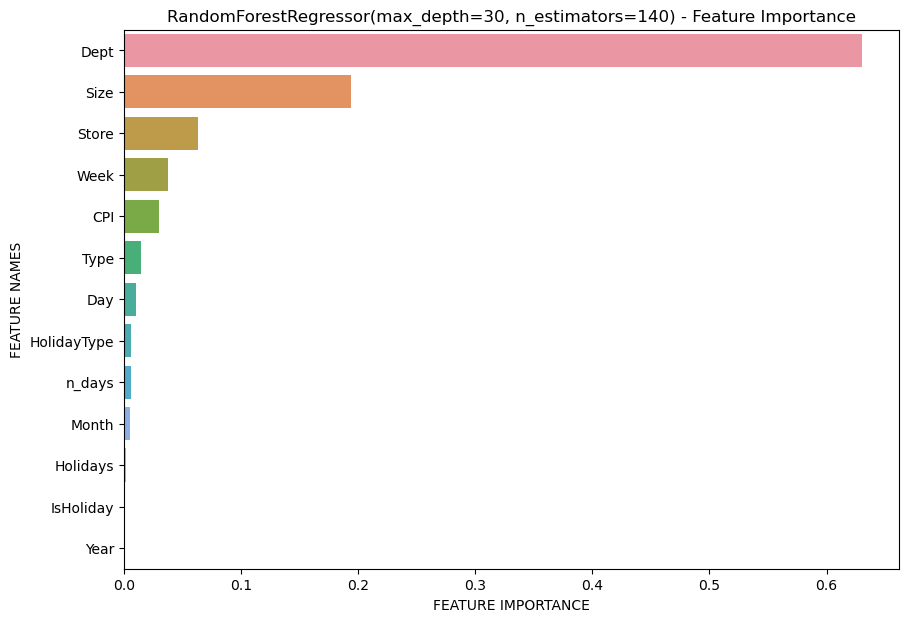

In [213]:
features_importance = RF.feature_importances_
   
plot_features_importance(
    features_importance,
    data.columns,
    RF
)

## Training Dataset with XGboost Regressor.

In [214]:
#this funtion will be training datset using GBDT Model
def gbdt(n_estimators, max_depth):
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                RF = lgb.LGBMRegressor(n_estimators=estimator, max_depth=depth)
                X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
                
                RF.fit(X_train, y_train)
                predicted = RF.predict(X_test)
                wmaes_cv.append(WMAE(X_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))

In [ ]:
max_depth = [20,25]
n_estimators = [6000,7000,8000]
gbdt(n_estimators, max_depth)

In [216]:
gb = lgb.LGBMRegressor(n_estimators=8000, max_depth=25)
gb.fit(data, train['Weekly_Sales'])

LGBMRegressor(max_depth=25, n_estimators=8000)

In [217]:
predict_Sales(gb,'2')

## Training Dataset with ElasticNet Regressor.

In [218]:
#this funtion will be training datset using Elastic Net(Linear Regression) Model
def linear_regression(l1_ratio):
    for l1 in l1_ratio:
          wmaes_cv = []
          for i in range(1,5):
              print('k:', i, ', l1_ratio:', l1)
              lr = ElasticNet(random_state=0,normalize = True,l1_ratio = l1)
              X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
              t = MinMaxScaler()
              t.fit(X_train)
              train_data = t.transform(X_train)
              test_data = t.transform(X_test)
              lr.fit(train_data, y_train)
              predicted = lr.predict(test_data)
              wmaes_cv.append(WMAE(X_test, y_test, predicted))
          print('WMAE:', np.mean(wmaes_cv))

In [220]:
l1_ratio = np.linspace(0.5, 1.0, num=6)
linear_regression(l1_ratio)

k: 1 , l1_ratio: 0.5
k: 2 , l1_ratio: 0.5
k: 3 , l1_ratio: 0.5
k: 4 , l1_ratio: 0.5
WMAE: 15332.2175
k: 1 , l1_ratio: 0.6
k: 2 , l1_ratio: 0.6
k: 3 , l1_ratio: 0.6
k: 4 , l1_ratio: 0.6
WMAE: 15347.992499999998
k: 1 , l1_ratio: 0.7
k: 2 , l1_ratio: 0.7
k: 3 , l1_ratio: 0.7
k: 4 , l1_ratio: 0.7
WMAE: 15325.495
k: 1 , l1_ratio: 0.8
k: 2 , l1_ratio: 0.8
k: 3 , l1_ratio: 0.8
k: 4 , l1_ratio: 0.8
WMAE: 15302.3675
k: 1 , l1_ratio: 0.9
k: 2 , l1_ratio: 0.9
k: 3 , l1_ratio: 0.9
k: 4 , l1_ratio: 0.9
WMAE: 15338.5975
k: 1 , l1_ratio: 1.0
k: 2 , l1_ratio: 1.0
k: 3 , l1_ratio: 1.0
k: 4 , l1_ratio: 1.0
WMAE: 14751.032500000001


In [219]:
lr = ElasticNet(random_state=0,normalize = True,l1_ratio = 1.0)
lr.fit(data, train['Weekly_Sales'])

ElasticNet(l1_ratio=1.0, normalize=True, random_state=0)

In [221]:
predict_Sales(lr,'3')